In [1]:
MOTIF_LENGTH = 1727
K_MEDOID_LENGTH = 157

# TODO: color for histogram, you can reference matplotlib website to change your color
css4_colors = ["magenta", "yellow", "aqua", "coral", "limegreen", "orange", "slategray"]

In [2]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install entropy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tslearn
!{sys.executable} -m pip install torchdrift
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install sktime

In [3]:
!pip install h5py

In [4]:
import numpy as np
from collections import Counter
from scipy.stats import entropy
import os
from itertools import combinations, product
import pandas as pd
from tslearn.metrics import dtw
from myf import calculate_f_jk, calculate_g_x
from joblib import Parallel, delayed
import pickle
from scipy import stats

calculate entropy of a sample (days,)

In [5]:
def my_entropy(data):
    # data is a class array
    # Calculate probabilities
    start = -1
    for i in range(len(data)):
        if data[i] == -1:
            data[i] = start
            start -= 1

    counts = Counter(data)
    probabilities = [count / len(data) for count in counts.values()]

    # Calculate Shannon entropy (base 2)
    shannon_entropy = entropy(probabilities)

    return shannon_entropy
    # print("Shannon Entropy:", shannon_entropy)

calculate MaximumMeanDiscrepancy between two samples with shape (batchsize, feature_nums = ts_length)

In [6]:
from torchdrift.detectors import kernel_mmd
import torch


def calculate_mmd(x, y):  # sample_num, features
    def replace_negative_ones_2d(arr):
        indices = np.where(arr == -1)
        count = 1
        for i in range(len(indices[0])):
            arr[indices[0][i], indices[1][i]] = -1 * count
            count += 1
        return arr

    x = replace_negative_ones_2d(x)
    y = replace_negative_ones_2d(y)

    # Convert numpy arrays to torch tensors
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Initialize the MMD metric
    metric = kernel_mmd(x_tensor, y_tensor)

    return metric  # MMD Score, p_value

for a set of samples(returned motifs), calculate avg_intra_cluster_distance to evaluate the density of the motifs (days,)

In [7]:
# need to change dist calculation
def avg_intra_cluster_distance(cluster):

    def compute_dtw(point, other_point):
        return dtw(point, other_point)

    n = len(cluster)
    indices = list(combinations(range(n), 2))
    distances = Parallel(n_jobs=-1)(
        delayed(compute_dtw)(cluster[i], cluster[j]) for i, j in indices
    )

    return np.mean(distances)

for evaluating diversity, intratrial or intertrial similarity. first need to sample and return a subset based on certain criteria

the following code is used to return sampled file names

In [8]:
# return file_list according to criteria(ex. which trial and which sex group...)
def get_samples(
    file_list,
    sample_num,
    trial=None,
    synthetic=None,
    sex=None,
    age=None,
    treatment=None,
    tir=None,
):

    # first exclude the ones not meet the criteria
    if trial is not None:
        file_list = [file for file in file_list if file[0] == trial]
    if synthetic is not None:
        file_list = [file for file in file_list if file[2] == str(synthetic)]
    if sex is not None:
        file_list = [file for file in file_list if file.split("_")[4][0] == str(sex)]
    if age is not None:
        file_list = [file for file in file_list if file.split("_")[4][1] == str(age)]
    if treatment is not None:
        file_list = [
            file for file in file_list if file.split("_")[4][2] == str(treatment)
        ]
    if tir is not None:
        file_list = [file for file in file_list if file.split("_")[4][3] == str(tir)]

    sample_num = min(sample_num, len(file_list))

    final_samples = np.array(file_list)

    if sample_num == 0:
        return None

    # Randomly selecting `sample_num` rows
    indices = np.random.choice(final_samples.shape[0], sample_num, replace=False)
    final_samples = final_samples[indices]

    # If you want a 2D array (sample_num, 1), reshape if needed:
    final_samples = final_samples.reshape(-1, 1)

    print("sample_num: ", sample_num)

    return final_samples  # (sample_num, 1)

give a file name, return a numpy array

In [9]:
def load_time_series(file, folder_name):  # for each file, please use parallel

    file_path = os.path.join(folder_name, file)
    data = np.load(file_path)  # (7, MOTIF_LENGTH) each segment
    return data

apply a sample and return motifs index and barycenter time series

In [10]:
# apply with a test sample or whole validation set
# data is (days, MOTIF_LENGTH)
def apply_motifs(motifs, tau, data):
    """
    motif_info = {
            "motif": {"pattern1": profiles[row], "pattern2": profiles[col]}#non transformed
            "pair_idx": (row, col),
            "score": min_value,
            "barycenter": barycenter,
        }
    """

    motif_num = len(motifs)
    data_num = len(data)
    # rows, each data, columns each motif, entry: dist
    dtw_matrix_validation = np.zeros((data_num, motif_num))
    # motif_num is motif_index
    indices = list(product(range(data_num), range(motif_num)))

    # inner function
    def min_distance(data_i, train_j):
        # train_j is a list or array with two profiles
        return min(
            calculate_f_jk(data_i, train_j["pattern1"]),
            calculate_f_jk(data_i, train_j["pattern2"]),
        )

    # j is motif index in motifs list, should be the same as motif index in info
    distances = Parallel(n_jobs=-1)(
        delayed(min_distance)(data[i], motifs[j]["motif"]) for i, j in indices
    )

    # Assign score into matrix
    for (i, j), dist in zip(indices, distances):
        dtw_matrix_validation[i, j] = dist

    my_mask = np.zeros(dtw_matrix_validation.shape, dtype=bool)

    masked = np.ma.masked_array(
        dtw_matrix_validation, mask=my_mask
    )  # mask need to match matrix shape (n, k)

    threshold = [motif["score"] + tau for motif in motifs]  # shape k
    threshold = np.array(threshold)

    # Create a new mask where entries are True if masked >= threshold (broadcasted)
    new_mask = masked >= threshold  # shape (n, k), broadcasting threshold

    # Combine with the existing mask (if any)
    combined_mask = np.logical_or(masked.mask, new_mask)

    # Apply the combined mask to get a new masked array
    masked = np.ma.masked_array(
        masked.data, mask=combined_mask
    )  # Now masked has entries masked where masked >= threshold (per column)

    # Set index to -1 where all values are masked
    min_indices = np.full(masked.shape[0], -1)
    for i, row in enumerate(masked):

        if not np.all(row.mask):
            min_indices[i] = np.argmin(row)

    min_barycenter = [
        (
            np.squeeze(motifs[idx]["barycenter"])
            if idx != -1
            else np.array(calculate_g_x(d))
        )
        for idx, d in zip(min_indices, data)
    ]

    return np.array(min_indices), np.array(
        min_barycenter
    )  # (n,) and (n, MOTIF_LENGTH) barycenter are transformed ones

apply a sample and return k_medoid center idx and center time series

In [11]:
def apply_k_medoids(
    threshold, val, km
):  # the val/test are nondownsampled and non logtransformed

    # val (days, MOTIF_LENGTH)

    downsampled_val = val[:, ::11]  # (days, K_MEDOID_LENGTH)

    log_val = np.apply_along_axis(calculate_g_x, axis=1, arr=downsampled_val)

    val_result = km.predict(log_val)

    centers = km.cluster_centers_

    def testing_threshold(threshold, log_val_e, val_result, centers):

        center = np.squeeze(
            centers[val_result]
        )  # (1, K_MEDOID_LENGTH) to (K_MEDOID_LENGTH)

        if dtw(log_val_e, center) >= threshold:

            return -1
        return val_result

    indices = list(range(len(log_val)))

    results = Parallel(n_jobs=-1)(
        delayed(testing_threshold)(threshold, log_val[i], val_result[i], centers)
        for i in indices
    )  # center idx results

    centers_results = [
        np.squeeze(centers[idx]) if idx != -1 else d for idx, d in zip(results, log_val)
    ]

    return np.array(results), np.array(centers_results)  # (n,) and (n, K_MEDOID_LENGTH)

#create a df for applying tableone

In [12]:
# metrics could be like entropy or avg intracluster distance
def create_features_df(file_list, metrics=None):
    trial = [file[0] for file in file_list]
    synthetic = [file[2] for file in file_list]

    sex = [file.split("_")[4][0] for file in file_list]
    age = [file.split("_")[4][1] for file in file_list]
    treatment = [file.split("_")[4][2] for file in file_list]
    tir = [file.split("_")[4][3] for file in file_list]
    # d = {'col1': [1, 2], 'col2': [3, 4]}
    d = {
        "trial": trial,
        "synthetic": synthetic,
        "sex": sex,
        "age": age,
        "treatment": treatment,
        "tir": tir,
    }
    if metrics is not None:
        d.update(metrics)

    df = pd.DataFrame(d)
    return df

#draw histogram

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


def draw_histogram(set_array, colors, subset_num):
    # Flatten all motif ids for each group
    group_flattened = []
    for group in set_array:
        group_flat = [
            item
            for case in group
            for item in (case if isinstance(case, (list, np.ndarray)) else [case])
        ]
        group_flattened.append(np.array(group_flat).flatten())

    # Find all unique values across all groups
    all_values = np.concatenate(group_flattened)
    unique_values = np.unique(all_values)
    print("unique_clusters: ", unique_values)

    bin_width = 0.8
    offsets = np.linspace(-bin_width / 2, bin_width / 2, subset_num)

    plt.figure(figsize=(16, 6))
    for i in range(subset_num):
        # Shift data by offset
        shifted_data = group_flattened[i] + offsets[i]

        sns.histplot(
            shifted_data,
            bins=np.arange(min(unique_values), max(unique_values) + 2, 1),
            kde=True,
            stat="count",
            color=colors[i],
            label=f"Class {i}",
            alpha=0.5,
            discrete=True,
            kde_kws={"bw_adjust": 0.1},
        )

    plt.xticks(np.arange(min(unique_values), max(unique_values) + 1, 1))
    plt.xlabel("Clusters")
    plt.ylabel("Frequency")
    plt.title("Histogram with KDE Curve by Subset")
    plt.legend()
    plt.show()

#draw t-SNE

In [14]:
from sklearn.manifold import TSNE


def draw_tsne(set_array, subset_num):
    # np_array: list of groups, each group is a list of arrays (cases), each array shape (days, MOTIF_LENGTH)
    # Flatten all cases in each group
    group_flattened = []
    for group in set_array:
        # group: list of arrays (cases)
        group_flat = []
        for case in group:
            case = np.array(case)  # (days, MOTIF_LENGTH)

            if case.ndim == 1:
                group_flat.append(case)
            else:
                group_flat.extend(case)

        group_flattened.append(np.array(group_flat))

    # Concatenate all groups for t-SNE
    data = np.concatenate(group_flattened, axis=0)
    labels = np.concatenate(
        [np.full(len(group_flattened[i]), i) for i in range(subset_num)]
    )

    # Apply t-SNE
    tsne = TSNE(
        n_components=2, random_state=42, perplexity=min(data.shape[0] * 0.3, 30)
    )
    tsne_result = tsne.fit_transform(data)

    # Plot t-SNE results
    plt.figure(figsize=(8, 6))
    for i in range(subset_num):
        plt.scatter(
            tsne_result[labels == i, 0], tsne_result[labels == i, 1], label=f"Class {i}"
        )

    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title("t-SNE Visualization of Cases")
    plt.legend()
    plt.show()

#apply pca for parallel

In [15]:
def apply_pca(pca, X):
    return pca.transform(X)

In [16]:
print(os.getcwd())

/home/rowan/Desktop/ProjectFiles/evaluation_models


#the following is the application code

#for you to know--part1: file format and labels



{trial_first_character}_ {synthetic} _ {id} _ {segment} _ {(sex)(age)(treatment)(tir)}

sex: {1: F, 2: M, 9: missing}

age: {0: <10, 1: <20, 2: <65, 3:>=65, 9: missing}

treatment: {0: MDI, 1: basic pump, 2: SAP, 3: CLP, 4, BP, 9: missing}

tir: {0: >90, 1: >70, 2: >50, 3: <=50, 9: missing}

#for you to know--part2: my idea about evaluation

for the test, i prepare two types of models. the first ones are motifs based models and the second ones are k medoids models.

i trained two types of models in respect to both single source and multi source datasets. so at final you would have 4 models in total.

**testset**
each test sample contains a group of 7 days data which are almost consecutive (but not definite).

**objectives**

1.   **to evaluate diversity of patterns of each subject**

for this object, my plan is to use entropy and mean distance between returned motifs from a segment belongs to a subject. you will apply each segment to "my_entropy" and "avg_intra_cluster_distance" and each segment should have a single value returned. the final shape should be like(sample_numb, 1)=(sample_numb, ) for a sampled set. because each segment has only one feature, we can apply Kolmogorov-Smirnov test (a nonparametric two sample test) for statistics evaluation.

2.   **to evaluate similarity of patterns between two groups**

  *   **1st method**:  each segment would have 7 motifs returned. we treat each segment as having 7 features. the shape of each group would be (sample_num, 7). the problem would becomes a multivariate two sample test. we thus use the MMD to evaluate the discrepancy.
  
      We also want to use the same method to evaluate the returned centers, but since returned centers are time series with length, the returned features are 2d instead of 1d. In this case, we apply PCA to compress the 2d features to 1d features and apply MMD.

      in the 1st method, the order of returned clusters matters.

  *  **2nd method**:  another method is to flatten returned motifs from a segment. makes each group's data to change from (sample_num, 7) to (sample_num*7, ). In this case, we could apply Kolmogorov-Smirnov test.
  
      And also for returned barycenters, if we apply the same flatten method, the final shape would be like (sample_num*7, ts_length) and apply MMD to evaluate.

      in the 2nd method, which segment the returned clusters belong to or order of the returned clusters do not matter. what we want to see, is the distribution of the overall clusters of a group.

unzip your test folder if needed
and load you motifs pickles and hyperparameters

In [17]:
# TODO: put myf.py, test_folders, motif pickle, k_medoid pickle and two pca pickles in your executive folder

# multi source model path
multi_motif_path = "9.236420021787648_3.694568008715059_multi_motifs.pkl"
multi_k_medoid_path = "k_medoids_multi_5.203641425222681_157.pkl"

# single source model
single_motif_path = "10.24240116345082_4.096960465380328_single_motifs.pkl"
single_k_medoid_path = "k_medoids_single_5.705711839785382_157.pkl"

# pca path
multi_motif_pca_path = "multi_motifs_pca_model.pkl"
multi_k_medoid_pca_path = "multi_k_medoids_pca_model.pkl"
single_motif_pca_path = "single_motifs_pca_model.pkl"
single_k_medoid_pca_path = "single_k_medoids_pca_model.pkl"


# load motif and k_medoid
with open(multi_motif_path, "rb") as f:
    multi_motif = pickle.load(f)

with open(multi_k_medoid_path, "rb") as f:
    multi_k_medoid = pickle.load(f)

with open(single_motif_path, "rb") as f:
    single_motif = pickle.load(f)

with open(single_k_medoid_path, "rb") as f:
    single_k_medoid = pickle.load(f)


# hyperparameters for motifs and k_medoids
multi_tau = float(multi_motif_path.split("_")[1])
multi_threshold = float(multi_k_medoid_path.split("_")[3])
single_tau = float(single_motif_path.split("_")[1])
single_threshold = float(single_k_medoid_path.split("_")[3])

# load pca
with open(multi_motif_pca_path, "rb") as f:
    multi_motif_pca = pickle.load(f)
with open(multi_k_medoid_pca_path, "rb") as f:
    multi_k_medoid_pca = pickle.load(f)
with open(single_motif_pca_path, "rb") as f:
    single_motif_pca = pickle.load(f)
with open(single_k_medoid_pca_path, "rb") as f:
    single_k_medoid_pca = pickle.load(f)


# load file list for single and multi
single_folder = "final_single_test"
single_file_list = os.listdir(single_folder)
multi_folder = "final_multi_test"
multi_file_list = os.listdir(multi_folder)

In [18]:
whole_multi_dataset = get_samples(
    multi_file_list, sample_num=len(multi_file_list)
)  # sample_num=multi_file_subject_num, 1
whole_multi_dataset = np.squeeze(whole_multi_dataset)
whole_multi_df = create_features_df(whole_multi_dataset)
# TODO: you can use whole_multi_df to decide your sample_num and groups you want to evaluate

sample_num:  16065


In [19]:
whole_single_dataset = get_samples(
    single_file_list, sample_num=len(single_file_list)
)  # sample_num=multi_file_subject_num, 1
whole_single_dataset = np.squeeze(whole_single_dataset)
whole_single_df = create_features_df(whole_single_dataset)
# TODO: you can use whole_single_df to decide your sample_num and groups you want to evaluate

sample_num:  22192


# **task1:** evaluate subject level cgm pattern diversity(motifs diversity) with respect to certain labels (ex. age, tir...)

use single source motif results

consider evaluate with respect to age groups / tir groups

we suspect in subject level, the diversity of child adolescent will be larger than elders? or as tir decrease, the diversity will increase?

the following code use age groups as an example

In [62]:
# TODO: try change sample_num, group

sample_num = 5  # random pick subject num

age_group = [0, 1, 2, 3]

entropy_samples = []

for age in age_group:
    # get subset of each age group in this case
    entropy_samples.append(
        get_samples(
            single_file_list,
            sample_num=sample_num,
            age=age,
        )
    )  # each entry shape (sample_num, random_pick_num)

sample_num:  5
sample_num:  5
sample_num:  5


In [63]:
# remove entropy_sample which is None

entropy_samples = [sample for sample in entropy_samples if sample is not None]
# TODO: please make sure for each entropy_sample in entropy_samples, the returned shape are the same

sample_num = entropy_samples[0].shape[0]  # real sample_num

entropy_datas = []
# enumerate through each group and get sampled data
for i in range(len(entropy_samples)):
    # entropy_sample[i]: sample_num, 1

    entropy_data = Parallel(n_jobs=-1)(
        delayed(load_time_series)(segment, single_folder)
        for sample in entropy_samples[i]
        for segment in sample
    )  # len(sample_nums) with each entry (7, MOTIF_LENGTH)

    entropy_data = np.array(entropy_data).reshape(
        sample_num, -1, MOTIF_LENGTH
    )  # sample_num, 7, MOTIF_LENGTH

    entropy_datas.append(entropy_data)

In [66]:
motif_entropy_list = []
motif_intra_sample_dist_list = []
k_medoid_entropy_list = []
k_medoid_intra_sample_dist_list = []

for entropy_data in entropy_datas:

    # apply parrallel motifs clustering to each case in a certain group
    motif_results = Parallel(n_jobs=2)(
        delayed(apply_motifs)(single_motif, single_tau, sample)
        for sample in entropy_data
    )  # len(sample_nums)

    motif_ids, motif_barycenters = zip(*motif_results)
    # shape(sample_nums, 7), (sample_nums, 7, MOTIF_LENGTH)
    motif_ids = np.array(motif_ids)
    motif_barycenters = np.array(motif_barycenters)
    print(motif_ids.shape)
    print(motif_barycenters.shape)

    entropy_result = Parallel(n_jobs=2)(
        delayed(my_entropy)(sample) for sample in motif_ids
    )  # (sample_num, ), each sampled subject has an entropy
    motif_entropy_list.append(entropy_result)  # (group_num, sample_nums)

    intra_sample_dist_result = Parallel(n_jobs=2)(
        delayed(avg_intra_cluster_distance)(sample) for sample in motif_barycenters
    )  # (sample_num, ), each sampled subject has an intra_subject_dist
    motif_intra_sample_dist_list.append(
        intra_sample_dist_result
    )  # (group_num, sample_nums)

    """do the same thing for k_medoid"""
    k_medoid_results = Parallel(n_jobs=2)(
        delayed(apply_k_medoids)(single_threshold, sample, single_k_medoid)
        for sample in entropy_data
    )  # len(sample_nums)
    k_medoid_ids, k_medoid_barycenters = zip(*k_medoid_results)
    # shape(sample_nums, 7), (sample_nums, 7, K_MEDOID_LENGTH)
    k_medoid_ids = np.array(k_medoid_ids)
    k_medoid_barycenters = np.array(k_medoid_barycenters)
    print(k_medoid_ids.shape)
    print(k_medoid_barycenters.shape)

    k_medoid_entropy_result = Parallel(n_jobs=2)(
        delayed(my_entropy)(sample) for sample in k_medoid_ids
    )  # (sample_num, )
    k_medoid_entropy_list.append(k_medoid_entropy_result)  # (group_num, sample_nums)

    k_medoid_intra_sample_dist_result = Parallel(n_jobs=2)(
        delayed(avg_intra_cluster_distance)(sample) for sample in k_medoid_barycenters
    )  # (sample_num, )
    k_medoid_intra_sample_dist_list.append(
        k_medoid_intra_sample_dist_result
    )  # (group_num, sample_nums)

# each subject may have multiple segment, but their demographics are the same
flatten_features = [
    sample[0] for entropy_sample in entropy_samples for sample in entropy_sample
]
flatten_motif_entropy = [
    entropy for entropys in motif_entropy_list for entropy in entropys
]
flatten_motif_intra_sample_dist = [
    intra_sample_dist
    for intra_sample_dists in motif_intra_sample_dist_list
    for intra_sample_dist in intra_sample_dists
]
flatten_k_medoid_entropy = [
    entropy for entropys in k_medoid_entropy_list for entropy in entropys
]
flatten_k_medoid_intra_sample_dist = [
    intra_sample_dist
    for intra_sample_dists in k_medoid_intra_sample_dist_list
    for intra_sample_dist in intra_sample_dists
]

KeyboardInterrupt: 

In [ ]:
diversity_df = create_features_df(
    flatten_features,
    {
        "motif_entropy": flatten_motif_entropy,
        "motif_intra_sample_dist": flatten_motif_intra_sample_dist,
        "k_medoid_entropy": flatten_k_medoid_entropy,
        "k_medoid_intra_sample_dist": flatten_k_medoid_intra_sample_dist,
    },
)
# TODO: please draw tableone from diversity_df, groupby the groups you choose
# TODO: you can also draw side by side boxplot
# TODO: please do above to some of the age groups and tir groups

n = len(motif_entropy_list)
indices = list(combinations(range(n), 2))
# TODO: apply two-sample Kolmogorov-Smirnov test for each pair of entropys and intra_sample_dist_result
# TODO: the following code only implement KS test on entropy, please remember to apply it on intra_sample_dist
# please evaluate the results
for i, j in indices:
    sample1 = motif_entropy_list[i]
    sample2 = motif_entropy_list[j]
    print(
        f"two-sample Kolmogorov-Smirnov test for group {i} and {j}: ",
        stats.ks_2samp(sample1, sample2),
    )

# **task2-1:** if choose several different subsets from the group, will the pattern distribution of these subsets be very different? implies there is no obvious pattern trends in this group?

use single source clusters here

we assume for age group elderly, tir group >90% and >70%. the patterns from different subjects may not differ so much. Which means there are some representative patterns in this group.

to evaluate pattern distribution based to labels(age, tir)

first draw histogram and t-SNE of the distribution of the whole group(here we treat each day as a data sample)

then choose 2-3 subset from the main group

draw histogram again

and draw tSNE

calculate MMD for returned cluster ids and pca centers

flatten returend ids and centers and calculate KS test and MMD for ids and centers

and create df for viewing features, are there any signigicant features difference in subsets that might explain the difference?

the following code take age group elderly(>=65) as an example

In [27]:
# TODO: try change sample_num, group

sample_num = 5  # random pick subject num

age_group = [3, 3]

In [28]:
# for visualization of whole elderly group
whole_elderly = get_samples(
    single_file_list,
    sample_num=sample_num,
    age=2,
)  # (total_case_num, random_pick_num)

print(whole_elderly.shape)

sample_num:  5
(5, 1)


In [ ]:
sample_num = whole_elderly.shape[0]  # real sample_num

# whole_elderly (total_case_num, 1)

whole_elderly_datas = Parallel(n_jobs=-1)(
    delayed(load_time_series)(segment, single_folder)
    for sample in whole_elderly
    for segment in sample
)  # len(sample_nums) with each entry (7,MOTIF_NUM)

whole_elderly_datas = np.array(whole_elderly_datas).reshape(
    sample_num, -1, MOTIF_LENGTH
)  # sample_num, 7, MOTIF_LENGTH

In [ ]:
# apply parrallel motifs clustering to each case in a certain group
whole_elderly_motifs = Parallel(n_jobs=-1)(
    delayed(apply_motifs)(single_motif, single_tau, sample)
    for sample in whole_elderly_datas
)  # len(sample_nums, )

whole_elderly_motif_ids, whole_elderly_motif_barycenters = zip(*whole_elderly_motifs)
# shape(sample_nums, 7), (sample_nums, 7, MOTIF_LENGTH)

whole_elderly_motif_ids = np.array(whole_elderly_motif_ids)
whole_elderly_motif_barycenters = np.array(whole_elderly_motif_barycenters)

In [ ]:
"""do the same thing for k_medoid"""

whole_elderly_k_medoid = Parallel(n_jobs=-1)(
    delayed(apply_k_medoids)(single_threshold, sample, single_k_medoid)
    for sample in whole_elderly_datas
)  # len(sample_nums)


whole_elderly_k_medoid_ids, whole_elderly_k_medoid_barycenters = zip(
    *whole_elderly_k_medoid
)


# shape(sample_nums, 7), (sample_nums, 7, MOTIF_LENGTH)


whole_elderly_k_medoid_ids = np.array(whole_elderly_k_medoid_ids)


whole_elderly_k_medoid_barycenters = np.array(whole_elderly_k_medoid_barycenters)

In [ ]:
elderly_samples = []  # used the save different subset


for age in age_group:

    # choose three different subset from the elderly group

    elderly_samples.append(
        get_samples(
            single_file_list,
            sample_num=sample_num,
            age=age,
        )
    )


# TODO: please make sure for each elderly_samples[i], the returned shape are the same

In [ ]:
# (elderly_samples[i], (samples_num, 1)
sample_num = elderly_samples[0].shape[0]  # real sample_num

elderly_samples_datas = []

for i in range(len(elderly_samples)):

    elderly_samples_data = Parallel(n_jobs=-1)(
        delayed(load_time_series)(segment, single_folder)
        for sample in elderly_samples[i]
        for segment in sample
    )  # len(samples_num) with each entry (7,MOTIF_NUM)

    elderly_samples_data = np.array(elderly_samples_data).reshape(
        sample_num, -1, MOTIF_LENGTH
    )  # sample_num, 7, MOTIF_LENGTH
    elderly_samples_datas.append(elderly_samples_data)

In [ ]:
grouped_motif_ids = [whole_elderly_motif_ids]
grouped_motif_barycenters = [whole_elderly_motif_barycenters]
grouped_k_medoid_ids = [whole_elderly_k_medoid_ids]
grouped_k_medoid_barycenters = [whole_elderly_k_medoid_barycenters]

for elderly_samples_data in elderly_samples_datas:

    # apply parrallel motifs clustering to each case in a certain group
    motif_results = Parallel(n_jobs=-1)(
        delayed(apply_motifs)(single_motif, single_tau, sample)
        for sample in elderly_samples_data
    )  # len(samples_num)
    motif_ids, motifs_barycenters = zip(*motif_results)
    # shape(samples_num, 7), (sample_nums, 7, MOTIF_NUM)
    motif_ids = np.array(motif_ids)  # (sample_nums, 7)
    motifs_barycenters = np.array(motifs_barycenters)  # (sample_nums, 7, MOTIF_NUM)

    grouped_motif_ids.append(motif_ids)
    grouped_motif_barycenters.append(motifs_barycenters)

    """do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""
    k_medoid_results = Parallel(n_jobs=-1)(
        delayed(apply_k_medoids)(single_threshold, sample, single_k_medoid)
        for sample in elderly_samples_data
    )  # len(samples_num)
    k_medoid_ids, k_medoid_barycenters = zip(*k_medoid_results)

    k_medoid_ids = np.array(k_medoid_ids)  # shape(samples_num, 7)
    k_medoid_barycenters = np.array(
        k_medoid_barycenters
    )  # shape(samples_num, 7, K_MEDOID_NUM)

    grouped_k_medoid_ids.append(k_medoid_ids)
    grouped_k_medoid_barycenters.append(k_medoid_barycenters)

In [ ]:
# draw histogram
# TODO: if you find your bars not aligned well with the unique clusters:
# try modify offsets = np.linspace(-bin_width / 2, bin_width / 2, subset_num) code in draw_histogram function
# modify the number until aligned well
# TODO: if there are too many classes, if may be hard to visualize, you can try visualize subsets of grouped_motif_ids
# like seperately draw histogram for grouped_motif_ids[0] and others
# TODO: if kde lines do not look right, try adjust kde_kws={"bw_adjust": 0.1},
# TODO: evaluate the plot, you also need to evalute the result between whole elderly set and the subsets
draw_histogram(
    grouped_motif_ids,
    css4_colors[:4],
    len(grouped_motif_ids),
)

In [ ]:
# draw tsne
# TODO: evaluate the plot
# TODO: if it is hard to visualize, you can draw tsne seperately for subsets of grouped_motif_barycenters
# like draw grouped_motif_barycenters[0] and others seperately
draw_tsne(
    grouped_motif_barycenters,
    len(grouped_motif_barycenters),
)

In [ ]:
# TODO: evaluate the ploy
draw_histogram(grouped_k_medoid_ids, css4_colors[:4], len(grouped_k_medoid_ids))

In [ ]:
# TODO: evaluate the plot
draw_tsne(
    grouped_k_medoid_barycenters,
    len(grouped_k_medoid_barycenters),
)

In [ ]:
# for returned motif_ids, calculate MMD between subsets
# grouped_motif_ids (subset_num, sample_nums, 7)
subset_grouped_motifs_id = np.array(grouped_motif_ids[1:])
print(subset_grouped_motifs_id.shape)

subset_grouped_motif_barycenters = np.array(grouped_motif_barycenters[1:])

"""do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""
subset_grouped_k_medoid_ids = np.array(grouped_k_medoid_ids[1:])
subset_grouped_k_medoid_barycenters = np.array(grouped_k_medoid_barycenters[1:])

n = len(subset_grouped_motifs_id)
indices = list(combinations(range(n), 2))

# apply MMD test for each pair of subsets
for i, j in indices:

    sample1 = subset_grouped_motifs_id[i]  # (sample_nums, 7)
    sample2 = subset_grouped_motifs_id[j]
    # TODO: evalute the results
    # the returend MMD metrics are MMD Score, p_value
    print(
        f"MMD test for motif cluster ids distribution of subset {i} and {j}: ",
        calculate_mmd(sample1, sample2),
    )

    centers_sample1 = subset_grouped_motif_barycenters[i]
    # (sample_num, days, MOTIF_LENGTH)
    centers_sample2 = subset_grouped_motif_barycenters[j]
    # pca (days, MOTIF_LENGTH) -> ((days, only one features)

    pca_centers_sample1 = Parallel(n_jobs=-1)(
        delayed(apply_pca)(single_motif_pca, sample) for sample in centers_sample1
    )  # len(samples_num)
    pca_centers_sample1 = np.squeeze(
        np.array(pca_centers_sample1)
    )  # (sample_num, days)

    pca_centers_sample2 = Parallel(n_jobs=-1)(
        delayed(apply_pca)(single_motif_pca, sample) for sample in centers_sample2
    )  # len(samples_num)
    pca_centers_sample2 = np.squeeze(
        np.array(pca_centers_sample2)
    )  # (sample_num, days)

    # TODO: evalute the results
    print(
        f"MMD test for motif pca cluster barycenters distribution of subset {i} and {j}: ",
        calculate_mmd(pca_centers_sample1, pca_centers_sample2),
    )

    # treat each day as a sample
    flatten_sample1 = sample1.reshape(-1)  # (sample_nums*7)
    flatten_sample2 = sample2.reshape(-1)
    # TODO: evalute the results
    print(
        f"KS test for motif ids distribution of subset {i} and {j}: ",
        stats.ks_2samp(flatten_sample1, flatten_sample2),
    )

    # treat each day as a sample
    flatten_centers_sample1 = centers_sample1.reshape(-1, MOTIF_LENGTH)
    flatten_centers_sample2 = centers_sample2.reshape(-1, MOTIF_LENGTH)
    # TODO: evalute the results
    print(
        f"MMD test for motif flatten cluster barycenters distribution of subset {i} and {j}: ",
        calculate_mmd(flatten_centers_sample1, flatten_centers_sample2),
    )

    """do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""
    sample1 = subset_grouped_k_medoid_ids[i]
    sample2 = subset_grouped_k_medoid_ids[j]
    # TODO: evalute the results
    print(
        f"MMD test for k medoid cluster ids distribution of subset {i} and {j}: ",
        calculate_mmd(sample1, sample2),
    )

    centers_sample1 = subset_grouped_k_medoid_barycenters[i]
    centers_sample2 = subset_grouped_k_medoid_barycenters[j]

    pca_centers_sample1 = Parallel(n_jobs=-1)(
        delayed(apply_pca)(single_k_medoid_pca, sample) for sample in centers_sample1
    )  # len(samples_num)
    pca_centers_sample1 = np.squeeze(
        np.array(pca_centers_sample1)
    )  # (sample_num, days)
    pca_centers_sample2 = Parallel(n_jobs=-1)(
        delayed(apply_pca)(single_k_medoid_pca, sample) for sample in centers_sample2
    )  # len(samples_num)
    pca_centers_sample2 = np.squeeze(
        np.array(pca_centers_sample2)
    )  # (sample_num, days)

    # TODO: evalute the results
    print(
        f"MMD test for k medoid pca cluster barycenters distribution of subset {i} and {j}: ",
        calculate_mmd(pca_centers_sample1, pca_centers_sample2),
    )

    flatten_sample1 = sample1.reshape(-1)
    flatten_sample2 = sample2.reshape(-1)
    # TODO: evalute the results
    print(
        f"KS test for k medoid ids distribution of subset {i} and {j}: ",
        stats.ks_2samp(flatten_sample1, flatten_sample2),
    )

    flatten_centers_sample1 = centers_sample1.reshape(-1, K_MEDOID_LENGTH)
    flatten_centers_sample2 = centers_sample2.reshape(-1, K_MEDOID_LENGTH)
    # TODO: evalute the results
    print(
        f"MMD test for k medoid flatten cluster barycenters distribution of subset {i} and {j}: ",
        calculate_mmd(flatten_centers_sample1, flatten_centers_sample2),
    )

# TODO: try to apply above codes to different age groups and tir groups in single source dataset

# take features table and evaluate if there is any significant differences in features that could explain the difference in subset
# elderly_samples, 3dimension
# TODO: please draw tableone from sample_df, groupby the groups you choose
# TODO: you can also draw side by side boxplot
flatten_features = [
    sample[0] for elderly_sample in elderly_samples for sample in elderly_sample
]
# TODO: in this df, because all groups come from the same basic age group
# you may need to generate another column for groupby to draw tableone
# from the above flatten_features we could know that: in this case, the first 5 samples come from subset 1, 6-10 come from subset 2
# you can use above infos to generate your groupby column
sample_df = create_features_df(flatten_features)

# **taks2-2:** evaluate patterns difference between different groups based on a specific label(ex. age, tir...)

we now have the discprepancy between subsets from the same label group. we are going to evaluate

> is there any significant pattern differences between different groups?

we are doing exactly the same thing for different groups as above

In [20]:
# TODO: try change sample_num, group

sample_num = 23  # random pick subject num

age_group = [ 2, 3]

In [21]:
elderly_samples = []  # used the save different subset

for age in age_group:
    # choose three different subset from the elderly group
    elderly_samples.append(
        get_samples(
            single_file_list,
            sample_num=sample_num,
            age=age,
        )
    )

elderly_samples = [sample for sample in elderly_samples if sample is not None]
# TODO: please make sure for each elderly_samples[i], the returned shape are the same

# Get reference shape from the first valid sample
reference_shape = elderly_samples[0].shape if elderly_samples else None

# Keep only samples with the same shape as the first one
elderly_samples = [
    sample for sample in elderly_samples
    if sample is not None and sample.shape == reference_shape
]
print("reference shape:")
print(reference_shape)
print(f"Number of consistent elderly samples: {len(elderly_samples)}")


sample_num:  23
sample_num:  23
reference shape:
(23, 1)
Number of consistent elderly samples: 2


In [22]:
# (elderly_samples[i], (samples_num, 1)
sample_num = elderly_samples[0].shape[0]  # real sample_num

elderly_samples_datas = []

for elderly_sample in elderly_samples:

    elderly_samples_data = Parallel(n_jobs=2)(
        delayed(load_time_series)(segment, single_folder)
        for sample in elderly_sample
        for segment in sample
    )  # len(samples_num) with each entry (7,MOTIF_NUM)

    elderly_samples_data = np.array(elderly_samples_data).reshape(
        sample_num, -1, MOTIF_LENGTH
    )  # sample_num, 7, MOTIF_LENGTH
    elderly_samples_datas.append(elderly_samples_data)

In [23]:
grouped_motif_ids = []
grouped_motif_barycenters = []
grouped_k_medoid_ids = []
grouped_k_medoid_barycenters = []

for elderly_samples_data in elderly_samples_datas:

    # apply parrallel motifs clustering to each case in a certain group
    motif_results = Parallel(n_jobs=2)(
        delayed(apply_motifs)(single_motif, single_tau, sample)
        for sample in elderly_samples_data
    )  # len(samples_num)
    motif_ids, motifs_barycenters = zip(*motif_results)
    # shape(samples_num, 7), (sample_nums, 7, MOTIF_NUM)
    motif_ids = np.array(motif_ids)  # (sample_nums, 7)
    motifs_barycenters = np.array(motifs_barycenters)  # (sample_nums, 7, MOTIF_NUM)

    grouped_motif_ids.append(motif_ids)
    grouped_motif_barycenters.append(motifs_barycenters)

    """do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""
    k_medoid_results = Parallel(n_jobs=2)(
        delayed(apply_k_medoids)(single_threshold, sample, single_k_medoid)
        for sample in elderly_samples_data
    )  # len(samples_num)
    k_medoid_ids, k_medoid_barycenters = zip(*k_medoid_results)

    k_medoid_ids = np.array(k_medoid_ids)  # shape(samples_num, 7)
    k_medoid_barycenters = np.array(
        k_medoid_barycenters
    )  # shape(samples_num, 7, K_MEDOID_NUM)

    grouped_k_medoid_ids.append(k_medoid_ids)
    grouped_k_medoid_barycenters.append(k_medoid_barycenters)

/home/rowan/miniconda3/envs/retry/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


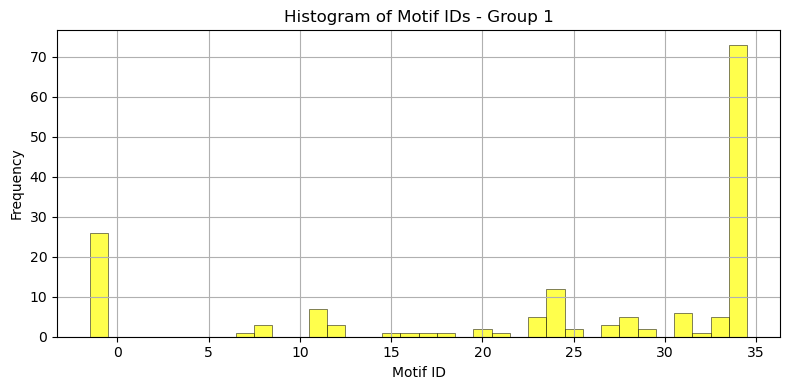

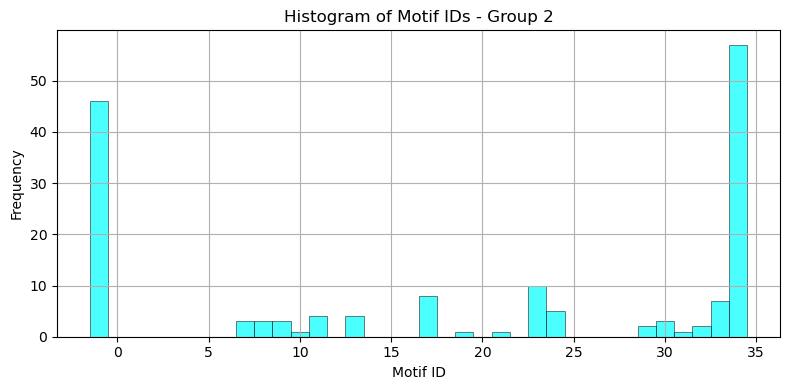

In [28]:
# draw histogram
# TODO: if you find your bars not aligned well with the unique clusters:
# try modify offsets = np.linspace(-bin_width / 2, bin_width / 2, subset_num) code in draw_histogram function
# modify the number until aligned well
# TODO: if there are too many classes, if may be hard to visualize, you can try draw several histogram to visualize some subsets of grouped_motif_ids
# TODO: if kde lines do not look right, try adjust kde_kws={"bw_adjust": 0.1},
# TODO: evaluate the plot
"""
draw_histogram(
    grouped_motif_ids,
    css4_colors[1:4],
    len(grouped_motif_ids),
)
"""
from itertools import chain

def draw_histograms_by_group(grouped_motif_ids, colors, kde=False, method_name='Motif'):
    bin_width = 1

    for i, values in enumerate(grouped_motif_ids):
        group_name = f"Group {i + 1}"

        # Flatten values
        flat_values = list(chain.from_iterable(
            v.tolist() if isinstance(v, np.ndarray) else v
            for v in values
        ))
        flat_values = np.array(flat_values)

        bins = np.arange(min(flat_values) - 0.5, max(flat_values) + 1.5, bin_width)

        plt.figure(figsize=(8, 4))
        plt.hist(
            flat_values,
            bins=bins,
            alpha=0.7,
            color=colors[i % len(colors)],
            edgecolor='black',
            linewidth=0.5,
        )

        if kde:
            sns.kdeplot(
                flat_values,
                bw_adjust=0.3,
                color=colors[i % len(colors)],
                linestyle="--"
            )

        plt.xlabel("Motif ID")
        plt.ylabel("Frequency")
        plt.title(f"Histogram of {method_name} IDs - {group_name}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
draw_histograms_by_group(
    grouped_motif_ids,
    css4_colors[1:len(grouped_motif_ids)+1],
    kde=False  # or True if you want to test KDE
)


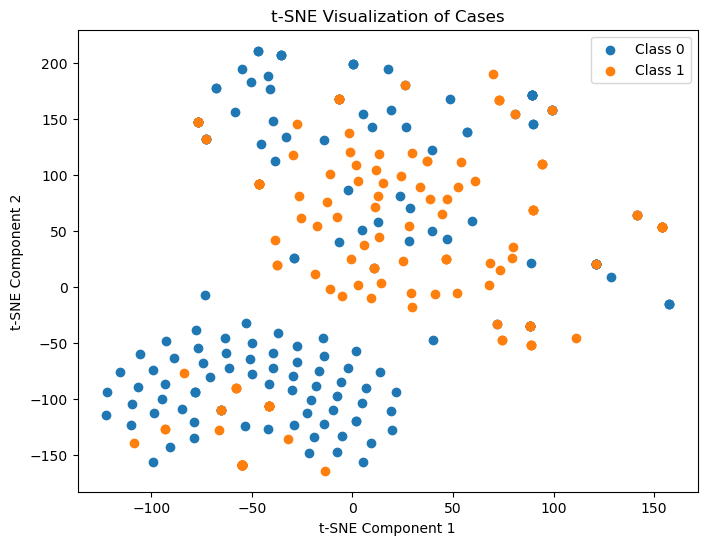

In [29]:
# draw tsne
# TODO: evaluate the plot
# TODO: if it is hard to visualize, you can draw tsne seperately for subsets of grouped_motif_barycenters
# like draw grouped_motif_barycenters[0] and others seperately
draw_tsne(
    grouped_motif_barycenters,
    len(grouped_motif_barycenters),
)


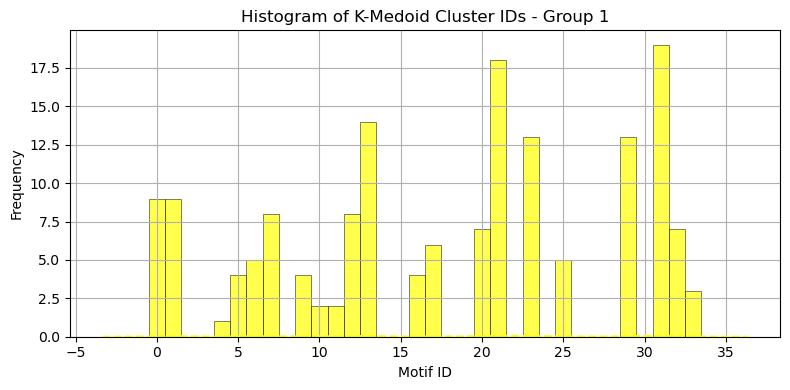

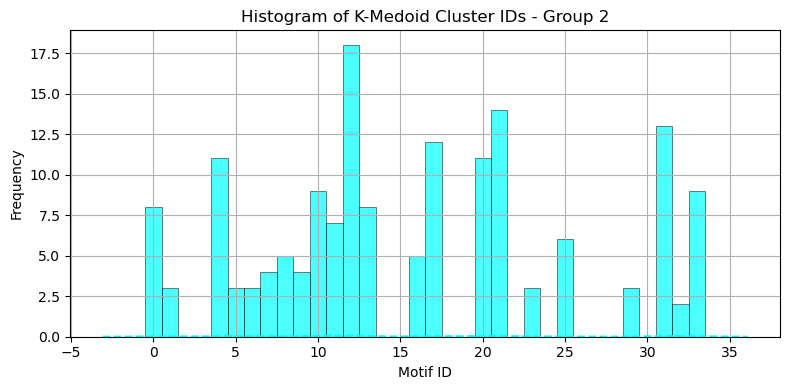

In [33]:
# TODO: evaluate the plot

draw_histograms_by_group(
    grouped_k_medoid_ids,
    css4_colors[1:4],
    len(grouped_k_medoid_ids),
    method_name="K-Medoid Cluster"
)

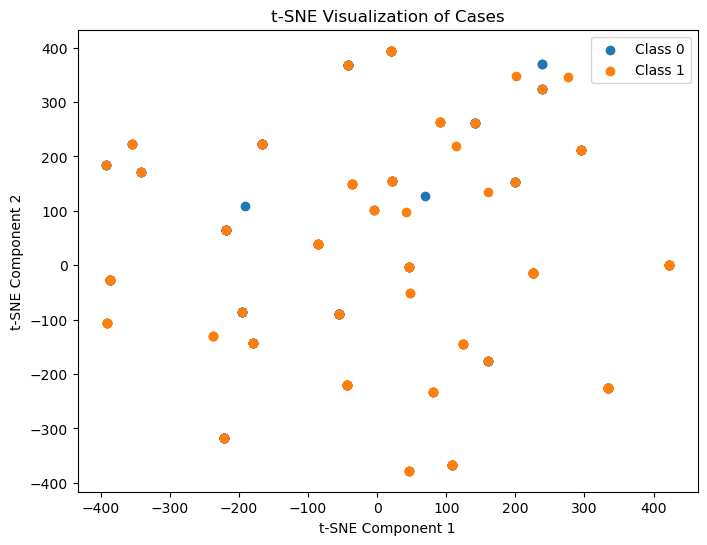

In [35]:
# TODO: evaluate the plot

draw_tsne(
    grouped_k_medoid_barycenters,
    len(grouped_k_medoid_barycenters),
)

In [37]:
!pip install tableone


MMD test for motif cluster ids distribution of subset 0 and 1:  (tensor(0.1160), tensor(0.0660))
MMD test for motif pca cluster barycenters distribution of subset 0 and 1:  (tensor(0.1170), tensor(0.0500))
KS test for motif ids distribution of subset 0 and 1:  KstestResult(statistic=0.17391304347826086, pvalue=0.01520785041643337, statistic_location=20, statistic_sign=-1)
MMD test for motif flatten cluster barycenters distribution of subset 0 and 1:  (tensor(0.0321), tensor(0.))
MMD test for k medoid cluster ids distribution of subset 0 and 1:  (tensor(0.1160), tensor(0.0580))
MMD test for k medoid pca cluster barycenters distribution of subset 0 and 1:  (tensor(0.1336), tensor(0.0300))
KS test for k medoid ids distribution of subset 0 and 1:  KstestResult(statistic=0.17391304347826086, pvalue=0.01520785041643337, statistic_location=20, statistic_sign=-1)
MMD test for k medoid flatten cluster barycenters distribution of subset 0 and 1:  (tensor(0.0343), tensor(0.))


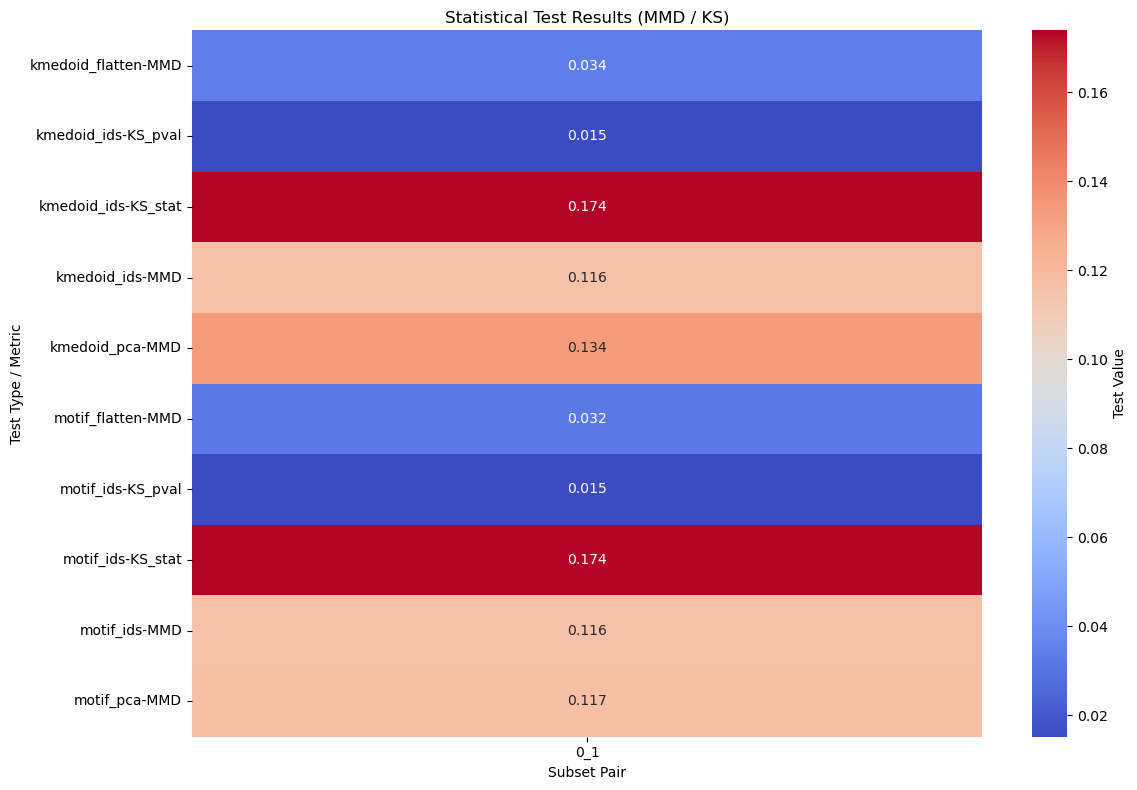

Index(['trial', 'synthetic', 'sex', 'age', 'treatment', 'tir'], dtype='object')


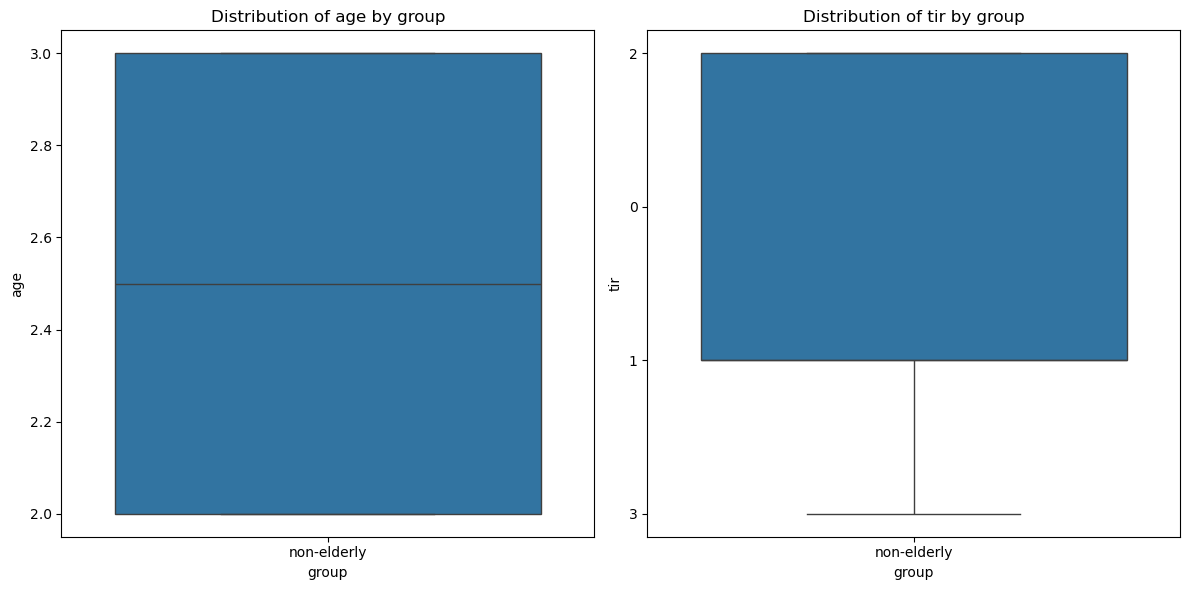

In [38]:
# === NEW ADDITIONS ARE MARKED WITH COMMENTS STARTING WITH "# ADDED ===="

from itertools import combinations
import numpy as np
from scipy import stats
from joblib import Parallel, delayed
from tableone import TableOne
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # ADDED ====

# === Assumed functions ===
# - calculate_mmd(sample1, sample2)
# - apply_pca(pca_model, sample)
# - create_features_df(flatten_features)
# - filter_samples_by_age(sample_df, age_range)
# - filter_samples_by_tir(sample_df, tir_range)

# === PREP ===
grouped_motif_ids = np.array(grouped_k_medoid_ids)
grouped_motif_barycenters = np.array(grouped_motif_barycenters)
grouped_k_medoid_ids = np.array(grouped_k_medoid_ids)
grouped_k_medoid_barycenters = np.array(grouped_k_medoid_barycenters)

n = len(grouped_motif_ids)
indices = list(combinations(range(n), 2))

# ADDED ==== Initialize storage for test results
test_results = []

for i, j in indices:
    pair = f"{i}_{j}"

    # Motif ID MMD
    sample1 = grouped_motif_ids[i]
    sample2 = grouped_motif_ids[j]
    mmd_motif_ids = calculate_mmd(sample1, sample2)
    print(f"MMD test for motif cluster ids distribution of subset {i} and {j}: ", mmd_motif_ids)
    test_results.append(("motif_ids", "MMD", pair, float(mmd_motif_ids[0])))

    # Motif PCA MMD
    centers_sample1 = grouped_motif_barycenters[i]
    centers_sample2 = grouped_motif_barycenters[j]
    pca_centers_sample1 = np.squeeze(np.array(Parallel(n_jobs=2)(delayed(apply_pca)(single_motif_pca, s) for s in centers_sample1)))
    pca_centers_sample2 = np.squeeze(np.array(Parallel(n_jobs=2)(delayed(apply_pca)(single_motif_pca, s) for s in centers_sample2)))
    mmd_motif_pca = calculate_mmd(pca_centers_sample1, pca_centers_sample2)
    print(f"MMD test for motif pca cluster barycenters distribution of subset {i} and {j}: ", mmd_motif_pca)
    test_results.append(("motif_pca", "MMD", pair, float(mmd_motif_pca[0])))

    # KS test for motif IDs
    flatten_sample1 = sample1.reshape(-1)
    flatten_sample2 = sample2.reshape(-1)
    ks_result = stats.ks_2samp(flatten_sample1, flatten_sample2)
    print(f"KS test for motif ids distribution of subset {i} and {j}: ", ks_result)
    test_results.append(("motif_ids", "KS_stat", pair, ks_result.statistic))
    test_results.append(("motif_ids", "KS_pval", pair, ks_result.pvalue))

    # MMD on flattened motif shapes
    flatten_centers_sample1 = centers_sample1.reshape(-1, MOTIF_LENGTH)
    flatten_centers_sample2 = centers_sample2.reshape(-1, MOTIF_LENGTH)
    mmd_motif_flatten = calculate_mmd(flatten_centers_sample1, flatten_centers_sample2)
    print(f"MMD test for motif flatten cluster barycenters distribution of subset {i} and {j}: ", mmd_motif_flatten)
    test_results.append(("motif_flatten", "MMD", pair, float(mmd_motif_flatten[0])))

    # k-medoid version
    sample1 = grouped_k_medoid_ids[i]
    sample2 = grouped_k_medoid_ids[j]
    mmd_kmedoid_ids = calculate_mmd(sample1, sample2)
    print(f"MMD test for k medoid cluster ids distribution of subset {i} and {j}: ", mmd_kmedoid_ids)
    test_results.append(("kmedoid_ids", "MMD", pair, float(mmd_kmedoid_ids[0])))

    centers_sample1 = grouped_k_medoid_barycenters[i]
    centers_sample2 = grouped_k_medoid_barycenters[j]
    pca_centers_sample1 = np.squeeze(np.array(Parallel(n_jobs=2)(delayed(apply_pca)(single_k_medoid_pca, s) for s in centers_sample1)))
    pca_centers_sample2 = np.squeeze(np.array(Parallel(n_jobs=2)(delayed(apply_pca)(single_k_medoid_pca, s) for s in centers_sample2)))
    mmd_kmedoid_pca = calculate_mmd(pca_centers_sample1, pca_centers_sample2)
    print(f"MMD test for k medoid pca cluster barycenters distribution of subset {i} and {j}: ", mmd_kmedoid_pca)
    test_results.append(("kmedoid_pca", "MMD", pair, float(mmd_kmedoid_pca[0])))

    flatten_sample1 = sample1.reshape(-1)
    flatten_sample2 = sample2.reshape(-1)
    ks_result = stats.ks_2samp(flatten_sample1, flatten_sample2)
    print(f"KS test for k medoid ids distribution of subset {i} and {j}: ", ks_result)
    test_results.append(("kmedoid_ids", "KS_stat", pair, ks_result.statistic))
    test_results.append(("kmedoid_ids", "KS_pval", pair, ks_result.pvalue))

    flatten_centers_sample1 = centers_sample1.reshape(-1, K_MEDOID_LENGTH)
    flatten_centers_sample2 = centers_sample2.reshape(-1, K_MEDOID_LENGTH)
    mmd_kmedoid_flatten = calculate_mmd(flatten_centers_sample1, flatten_centers_sample2)
    print(f"MMD test for k medoid flatten cluster barycenters distribution of subset {i} and {j}: ", mmd_kmedoid_flatten)
    test_results.append(("kmedoid_flatten", "MMD", pair, float(mmd_kmedoid_flatten[0])))

# ADDED ==== Create DataFrame and Heatmap
df_stats = pd.DataFrame(test_results, columns=["test", "metric", "subset", "value"])
df_pivot = df_stats.pivot_table(index=["test", "metric"], columns="subset", values="value")

plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'Test Value'})
plt.title("Statistical Test Results (MMD / KS)")
plt.ylabel("Test Type / Metric")
plt.xlabel("Subset Pair")
plt.tight_layout()
plt.show()

# ADDED ==== Age/TIR Group Evaluations ====

age_groups = [(0, 18), (18, 65), (65, 120)]
tir_groups = [(0, 60), (60, 80), (80, 100)]

def run_tests_on_group(group_name, grouped_ids, grouped_barycenters):
    print(f"\n--- Group: {group_name} ---")
    for i, j in combinations(range(len(grouped_ids)), 2):
        print(f"\nSubset {i} vs {j}")
        print("MMD on IDs:", calculate_mmd(grouped_ids[i], grouped_ids[j]))
        print("KS on IDs:", stats.ks_2samp(grouped_ids[i].reshape(-1), grouped_ids[j].reshape(-1)))
        print("MMD on flattened shapes:", calculate_mmd(grouped_barycenters[i].reshape(-1, grouped_barycenters[i].shape[-1]), grouped_barycenters[j].reshape(-1, grouped_barycenters[j].shape[-1])))

# ADDED ==== TableOne and Boxplots ====

flatten_features = [sample[0] for elderly_sample in elderly_samples for sample in elderly_sample]
sample_df = create_features_df(flatten_features)
print(sample_df.columns)

# TableOne

# Step 1: Convert 'age' to numeric
sample_df['age'] = pd.to_numeric(sample_df['age'], errors='coerce')

# Step 2: Drop rows with missing or invalid age values
sample_df = sample_df.dropna(subset=['age'])

# Step 3: Create group column
sample_df['group'] = sample_df['age'].apply(lambda x: 'elderly' if x >= 65 else 'non-elderly')

# Step 4: Boxplots for continuous features (age, tir)
plt.figure(figsize=(12, 6))
for i, col in enumerate(['age', 'tir']):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(data=sample_df, x='group', y=col)
    plt.title(f'Distribution of {col} by group')
    plt.tight_layout()
plt.show()


# **task2-3:** for domain shifting

we now know the patterns trend in a certain group, and the discrepancy between different groups based on a certain label.

we are going to evaluate

> for the same background. do samples come from multi source dataset have similar pattern distribution as single source dataset?

we get samples from each domain(single source and multi source) under similar background(ex. the same age group) and evaluate if there is any dicrepancy between clusters distribution of two samples.

draw hisogram, tsne to visualize.

calculate MMD for returned cluster ids and pca centers

flatten returend ids and centers and calculate KS test and MMD for ids and centers

draw feature tables to see if there is any other feautres with signigicant difference

the following use elderly as an example

we use single source motifs and k medoids to evaluate here

In [60]:
# TODO: try change sample_num, group

sample_num = 23  # random pick subject num

single_elderly = get_samples(single_file_list, sample_num=sample_num, age=3)
# sample_num, random_pick_num
multi_elderly = get_samples(multi_file_list, sample_num=sample_num, age=3)

# TODO: please make sure for single_elderly and multi_elderly, the returned shape are the same

sample_num = single_elderly.shape[0]  # real sample_num, 1
assert single_elderly.shape == multi_elderly.shape, "Shape mismatch — adjust sampling."


sample_num:  23
sample_num:  23


In [61]:
single_elderly_datas = Parallel(n_jobs=2)(
    delayed(load_time_series)(segment, single_folder)
    for sample in single_elderly
    for segment in sample
)  # len(samples) with each entry (7, MOTIF_NUM)

single_elderly_datas = np.array(single_elderly_datas).reshape(
    sample_num, -1, MOTIF_LENGTH
)  # sample_num, 7, MOTIF_LENGTH

multi_elderly_datas = Parallel(n_jobs=2)(
    delayed(load_time_series)(segment, multi_folder)
    for sample in multi_elderly
    for segment in sample
)

multi_elderly_datas = np.array(multi_elderly_datas).reshape(
    sample_num, -1, MOTIF_LENGTH
)

In [62]:
print(single_elderly_datas.nbytes)


2224376


In [64]:
print("Single elderly datas:", single_elderly_datas.shape)
print("Single elderly memory (MB):", single_elderly_datas.nbytes / (1024 * 1024))

print("Multi elderly datas:", multi_elderly_datas.shape)
print("Multi elderly memory (MB):", multi_elderly_datas.nbytes / (1024 * 1024))

test = apply_motifs(single_motif, single_tau, single_elderly_datas[0])


Single elderly datas: (23, 7, 1727)
Single elderly memory (MB): 2.1213302612304688
Multi elderly datas: (23, 7, 1727)
Multi elderly memory (MB): 2.1213302612304688


In [ ]:
# apply parrallel motifs clustering to each case in a certain group
single_elderly_motifs = Parallel(n_jobs=2)(
    delayed(apply_motifs)(single_motif, single_tau, sample)
    for sample in single_elderly_datas
)  # len(samples)

multi_elderly_motifs = Parallel(n_jobs=2)(
    delayed(apply_motifs)(single_motif, single_tau, sample)
    for sample in multi_elderly_datas
)  # len(samples)

single_elderly_motif_ids, single_elderly_motifs_barycenters = zip(
    *single_elderly_motifs
)
# (sample_num, 7), #(sample_num, days, MOTIF_NUM)
single_elderly_motif_ids = np.array(single_elderly_motif_ids)
single_elderly_motifs_barycenters = np.array(single_elderly_motifs_barycenters)

multi_elderly_motif_ids, multi_elderly_motifs_barycenters = zip(*multi_elderly_motifs)
multi_elderly_motif_ids = np.array(multi_elderly_motif_ids)
multi_elderly_motifs_barycenters = np.array(multi_elderly_motifs_barycenters)

"""do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""

single_elderly_k_modoid = Parallel(n_jobs=2)(
    delayed(apply_k_medoids)(single_threshold, sample, single_k_medoid)
    for sample in single_elderly_datas
)  # len(samples)

multi_elderly_k_modoid = Parallel(n_jobs=2)(
    delayed(apply_k_medoids)(single_threshold, sample, single_k_medoid)
    for sample in multi_elderly_datas
)  # len(samples)

single_elderly_k_medoid_ids, single_elderly_k_medoid_barycenters = zip(
    *single_elderly_k_modoid
)

single_elderly_k_medoid_ids = np.array(single_elderly_k_medoid_ids)
single_elderly_k_medoid_barycenters = np.array(single_elderly_k_medoid_barycenters)

multi_elderly_k_medoid_ids, multi_elderly_k_medoid_barycenters = zip(
    *multi_elderly_k_modoid
)

multi_elderly_k_medoid_ids = np.array(multi_elderly_k_medoid_ids)
multi_elderly_k_medoid_barycenters = np.array(multi_elderly_k_medoid_barycenters)

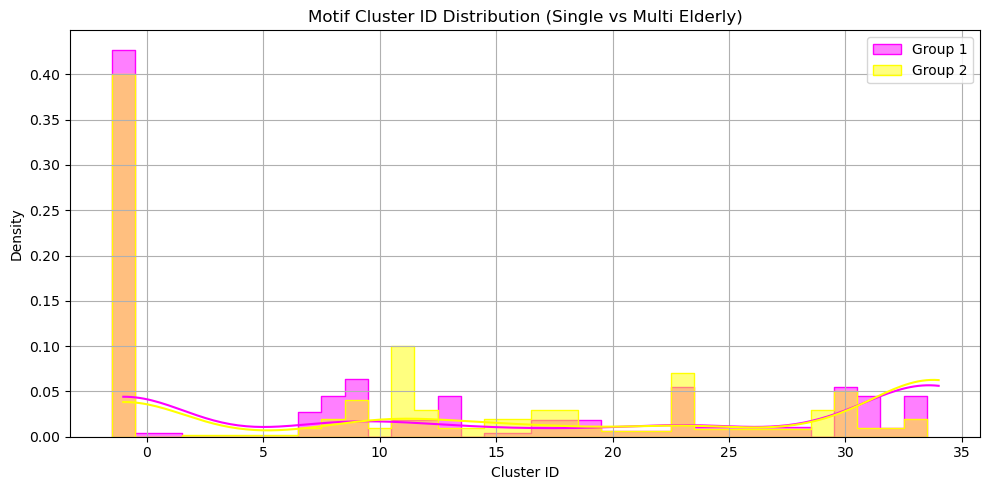

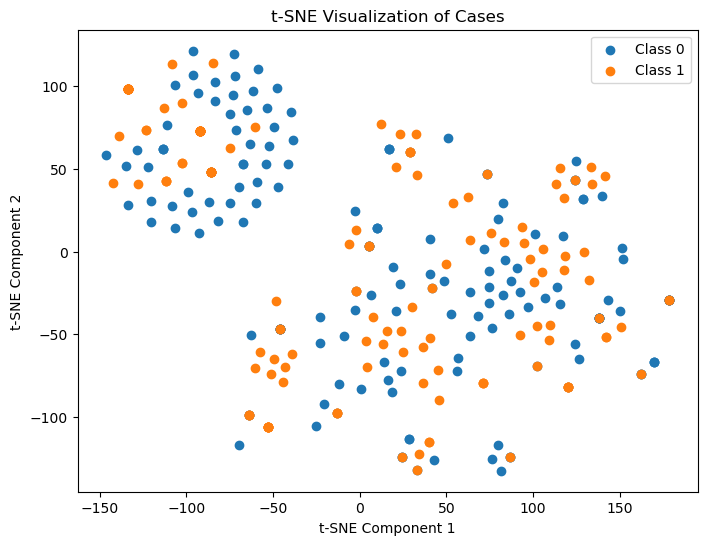

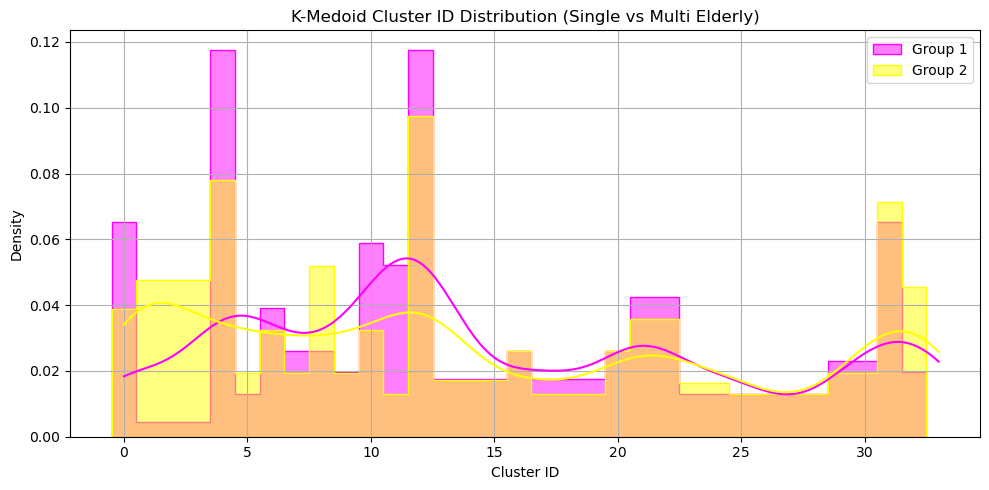

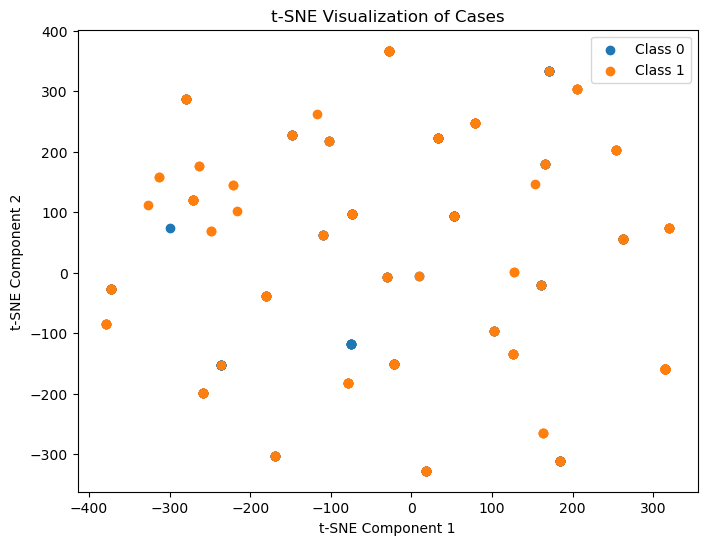

In [66]:
# === Prepare motif cluster IDs and barycenters ===
concat_motif_ids = [single_elderly_motif_ids, multi_elderly_motif_ids]
concat_motif_barycenters = [
    single_elderly_motifs_barycenters,
    multi_elderly_motifs_barycenters,
]

# === DRAW HISTOGRAM for motif clusters with improved method ===
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def draw_aligned_histogram(cluster_ids_list, colors, subset_num, kde=True, title="Histogram of Cluster IDs"):
    """
    Custom histogram drawing with offset bin alignment and KDE tuning.
    - cluster_ids_list: list of np.arrays, shape (samples, days)
    - colors: list of color strings
    - subset_num: number of groups (e.g. 2: single vs multi)
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    # Flatten and stack all IDs to get unique bins
    all_ids_flat = np.concatenate([ids.flatten() for ids in cluster_ids_list])
    unique_bins = np.unique(all_ids_flat)
    bin_width = 0.8
    offsets = np.linspace(-bin_width / 2, bin_width / 2, subset_num)

    for i, ids in enumerate(cluster_ids_list):
        flat_ids = ids.flatten()
        # Plot histogram with KDE
        sns.histplot(
            flat_ids,
            bins=unique_bins - 0.5,
            kde=kde,
            kde_kws={"bw_adjust": 0.5},  # <-- Tune this if KDE looks off
            color=colors[i],
            label=f'Group {i + 1}',
            ax=ax,
            element="step",
            stat="density",  # normalize for comparison
            common_norm=False
        )

    ax.set_title(title)
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("Density")
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Use improved histogram for motifs ===
draw_aligned_histogram(
    concat_motif_ids,
    css4_colors[0:2],
    subset_num=len(concat_motif_ids),
    kde=True,
    title="Motif Cluster ID Distribution (Single vs Multi Elderly)"
)

# === Draw t-SNE for motif barycenters ===
draw_tsne(concat_motif_barycenters, len(concat_motif_barycenters))

# ============================================================
# === Repeat the same for k-medoid clusters ================
# ============================================================

concat_k_medoid_ids = [single_elderly_k_medoid_ids, multi_elderly_k_medoid_ids]
concat_k_medoid_barycenters = [
    single_elderly_k_medoid_barycenters,
    multi_elderly_k_medoid_barycenters,
]

# === Use improved histogram for k-medoids ===
draw_aligned_histogram(
    concat_k_medoid_ids,
    css4_colors[0:2],
    subset_num=len(concat_k_medoid_ids),
    kde=True,
    title="K-Medoid Cluster ID Distribution (Single vs Multi Elderly)"
)

# === Draw t-SNE for k-medoid barycenters ===
draw_tsne(concat_k_medoid_barycenters, len(concat_k_medoid_barycenters))


In [71]:
from scipy import stats
import numpy as np
from joblib import Parallel, delayed
from tableone import TableOne
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ---------- Domain names for printout ----------
domain_1 = "Single Elderly"
domain_2 = "Multi Elderly"

# ---------- Motif Clusters ----------
motif_ids1 = concat_motif_ids[0]
motif_ids2 = concat_motif_ids[1]

print(f"\n=== Motif Cluster ID Distribution ({domain_1} vs {domain_2}) ===")
mmd_score, p = calculate_mmd(motif_ids1, motif_ids2)
print(f"📊 MMD: score = {mmd_score:.4f}, p = {p:.4f}")
print("✅ Similar" if p >= 0.05 else "❌ Different")

ks_stat, ks_p = stats.ks_2samp(motif_ids1.reshape(-1), motif_ids2.reshape(-1))
print(f"📈 KS: stat = {ks_stat:.4f}, p = {ks_p:.4f}")
print("✅ Similar" if ks_p >= 0.05 else "❌ Different")

motif_centers1 = concat_motif_barycenters[0]
motif_centers2 = concat_motif_barycenters[1]

motif_pca1 = np.squeeze(np.array(Parallel(n_jobs=2)(delayed(apply_pca)(single_motif_pca, s) for s in motif_centers1)))
motif_pca2 = np.squeeze(np.array(Parallel(n_jobs=2)(delayed(apply_pca)(single_motif_pca, s) for s in motif_centers2)))

print(f"\n=== Motif PCA Barycenters ({domain_1} vs {domain_2}) ===")
mmd_score, p = calculate_mmd(motif_pca1, motif_pca2)
print(f"📊 MMD: score = {mmd_score:.4f}, p = {p:.4f}")
print("✅ Similar" if p >= 0.05 else "❌ Different")

motif_flatten1 = motif_centers1.reshape(-1, MOTIF_LENGTH)
motif_flatten2 = motif_centers2.reshape(-1, MOTIF_LENGTH)

print(f"\n=== Motif Flattened Barycenters ({domain_1} vs {domain_2}) ===")
mmd_score, p = calculate_mmd(motif_flatten1, motif_flatten2)
print(f"📊 MMD: score = {mmd_score:.4f}, p = {p:.4f}")
print("✅ Similar" if p >= 0.05 else "❌ Different")

# ---------- K-Medoid Clusters ----------
k_ids1 = concat_k_medoid_ids[0]
k_ids2 = concat_k_medoid_ids[1]

print(f"\n=== K-Medoid Cluster ID Distribution ({domain_1} vs {domain_2}) ===")
mmd_score, p = calculate_mmd(k_ids1, k_ids2)
print(f"📊 MMD: score = {mmd_score:.4f}, p = {p:.4f}")
print("✅ Similar" if p >= 0.05 else "❌ Different")

ks_stat, ks_p = stats.ks_2samp(k_ids1.reshape(-1), k_ids2.reshape(-1))
print(f"📈 KS: stat = {ks_stat:.4f}, p = {ks_p:.4f}")
print("✅ Similar" if ks_p >= 0.05 else "❌ Different")

k_centers1 = concat_k_medoid_barycenters[0]
k_centers2 = concat_k_medoid_barycenters[1]

k_pca1 = np.squeeze(np.array(Parallel(n_jobs=2)(delayed(apply_pca)(single_k_medoid_pca, s) for s in k_centers1)))
k_pca2 = np.squeeze(np.array(Parallel(n_jobs=2)(delayed(apply_pca)(single_k_medoid_pca, s) for s in k_centers2)))

print(f"\n=== K-Medoid PCA Barycenters ({domain_1} vs {domain_2}) ===")
mmd_score, p = calculate_mmd(k_pca1, k_pca2)
print(f"📊 MMD: score = {mmd_score:.4f}, p = {p:.4f}")
print("✅ Similar" if p >= 0.05 else "❌ Different")

k_flatten1 = k_centers1.reshape(-1, K_MEDOID_LENGTH)
k_flatten2 = k_centers2.reshape(-1, K_MEDOID_LENGTH)

print(f"\n=== K-Medoid Flattened Barycenters ({domain_1} vs {domain_2}) ===")
mmd_score, p = calculate_mmd(k_flatten1, k_flatten2)
print(f"📊 MMD: score = {mmd_score:.4f}, p = {p:.4f}")
print("✅ Similar" if p >= 0.05 else "❌ Different")

# ---------- TableOne / Side-by-Side Plots ----------
concat_elderly = [single_elderly, multi_elderly]
flatten_features = []
domain_labels = []

for group, label in zip(concat_elderly, [domain_1, domain_2]):
    for s in group:
        flatten_features.append(s[0])
        domain_labels.append(label)

domain_df = create_features_df(flatten_features)
domain_df["domain"] = domain_labels

# Define columns and categorical variables
columns = [col for col in domain_df.columns if col not in ['domain', 'trial', 'synthetic']]
categorical = [col for col in columns if domain_df[col].dtype == 'object' or domain_df[col].dtype.name == 'category']

print("\n=== TableOne Summary by Domain ===")
table1 = TableOne(domain_df, columns=columns, categorical=categorical, groupby='domain')
print(table1)

# --- Calculate p-values for each variable comparing domain_1 vs domain_2 ---
def compute_pval(df, col, group_col='domain'):
    group1 = df[df[group_col] == domain_1][col].dropna()
    group2 = df[df[group_col] == domain_2][col].dropna()
    
    if col in categorical:
        # Categorical variable: use Chi-square or Fisher's exact test
        contingency = pd.crosstab(df[col], df[group_col])
        if contingency.values.min() < 5:
            # Use Fisher's exact test for small counts (only for 2x2 tables)
            if contingency.shape == (2, 2):
                _, pval = stats.fisher_exact(contingency)
            else:
                # fallback: chi2 test if not 2x2
                _, pval, _, _ = stats.chi2_contingency(contingency)
        else:
            _, pval, _, _ = stats.chi2_contingency(contingency)
    else:
        # Continuous variable: test for normality (Shapiro)
        # If normal, use t-test; else Mann-Whitney U test
        norm1 = stats.shapiro(group1.sample(min(len(group1), 5000), random_state=42))[1] > 0.05 if len(group1) > 3 else False
        norm2 = stats.shapiro(group2.sample(min(len(group2), 5000), random_state=42))[1] > 0.05 if len(group2) > 3 else False
        
        if norm1 and norm2:
            _, pval = stats.ttest_ind(group1, group2, nan_policy='omit')
        else:
            _, pval = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    return pval

pvals = {col: compute_pval(domain_df, col) for col in columns}

# Show p-values nicely:
pval_df = pd.DataFrame.from_dict(pvals, orient='index', columns=['p-value'])
pval_df['p-value'] = pval_df['p-value'].apply(lambda x: f"{x:.4g}")

print("\n=== P-values comparing domains ===")
print(pval_df)

print("\nColumns in domain_df:")
print(domain_df.columns)



=== Motif Cluster ID Distribution (Single Elderly vs Multi Elderly) ===
📊 MMD: score = 0.0993, p = 0.2240
✅ Similar
📈 KS: stat = 0.0932, p = 0.4882
✅ Similar

=== Motif PCA Barycenters (Single Elderly vs Multi Elderly) ===
📊 MMD: score = 0.0832, p = 0.6740
✅ Similar

=== Motif Flattened Barycenters (Single Elderly vs Multi Elderly) ===
📊 MMD: score = 0.0150, p = 0.1310
✅ Similar

=== K-Medoid Cluster ID Distribution (Single Elderly vs Multi Elderly) ===
📊 MMD: score = 0.0769, p = 0.8620
✅ Similar
📈 KS: stat = 0.0994, p = 0.4054
✅ Similar

=== K-Medoid PCA Barycenters (Single Elderly vs Multi Elderly) ===
📊 MMD: score = 0.0855, p = 0.5200
✅ Similar

=== K-Medoid Flattened Barycenters (Single Elderly vs Multi Elderly) ===
📊 MMD: score = 0.0145, p = 0.1550
✅ Similar

=== TableOne Summary by Domain ===
                   Grouped by domain                                         
                             Missing     Overall Multi Elderly Single Elderly
n                                

# **task3:** to evaluate models' performance on smaller trials

in multi souce dataset, there are some trials with smaller numbers of subjects. this experiment is gonna evaluate if any smaller trials would be sacrifice.

the easiest way is to evaluate how many test cases are nonclassified in each trial

we use multi source motifs and k medoids to evaluate here

In [ ]:
# TODO: try change sample_num
sample_num = 5  # random pick subject num

trial_group = ["a", "b", "l", "t", "w"]

In [ ]:
trial_samples = []

for trial in trial_group:
    # choose several subjects under similar background
    trial_samples.append(
        get_samples(
            multi_file_list,
            sample_num=sample_num,
            trial=trial,
        )
    )  # each entry shape(sample_num, 1)

# NOTE: sample_num of different trials could be different

In [ ]:
grouped_motif_ids = []
grouped_k_medoid_ids = []

for trial_sample in trial_samples:

    trial_samples_datas = Parallel(n_jobs=-1)(
        delayed(load_time_series)(segment, multi_folder)
        for sample in trial_sample
        for segment in sample
    )  # len(samples_num[i]) with each entry (7, MOTIF_NUM)

    trial_samples_datas = np.array(trial_samples_datas).reshape(
        -1, 7, MOTIF_LENGTH
    )  # sample_num[i], 7, MOTIF_LENGTH

    # apply parrallel motifs clustering to each case in a certain group
    motif_results = Parallel(n_jobs=-1)(
        delayed(apply_motifs)(multi_motif, multi_tau, sample)
        for sample in trial_samples_datas
    )  # len(sample_num[i])

    motif_ids, _ = zip(*motif_results)
    # sample_num[i], 7
    motif_ids = np.array(motif_ids)

    grouped_motif_ids.append(motif_ids)

    """do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""
    k_medoid_results = Parallel(n_jobs=-1)(
        delayed(apply_k_medoids)(multi_threshold, sample, multi_k_medoid)
        for sample in trial_samples_datas
    )  # len(sample_num[i])
    k_medoid_ids, _ = zip(*k_medoid_results)

    k_medoid_ids = np.array(k_medoid_ids)

    grouped_k_medoid_ids.append(k_medoid_ids)

# TODO:evaluate the unclassified ratio of each trial
for trial_motif_ids, trial_k_medoid_ids, trial in zip(
    grouped_motif_ids, grouped_k_medoid_ids, trial_group
):

    trial_motif_ids = trial_motif_ids.flatten()  # sample_num[i], 7 to sample_num[i]* 7
    unclassified_motif_ids = trial_motif_ids[trial_motif_ids < 0]
    unclassified_motif_ratio = len(unclassified_motif_ids) / len(trial_motif_ids)

    trial_k_medoid_ids = trial_k_medoid_ids.flatten()
    unclassified_k_medoid_ids = trial_k_medoid_ids[trial_k_medoid_ids < 0]
    unclassified_k_medoid_ratio = len(unclassified_k_medoid_ids) / len(
        trial_k_medoid_ids
    )
    print(f"unclassified motifs ratio of trial {trial} is: ", unclassified_motif_ratio)
    print(
        f"unclassified K medoids ratio of trial {trial} is: ",
        unclassified_k_medoid_ratio,
    )

# **task4:** to evaluate if there is any different in distribution between synthetic and non-synthetic healthy subject

we have many synthetic healthy data. what we want to evaluate is

> is there any pattern distribution discrepancy between synthetic healthy cgm and real world healhty cgm

the goal is to evaluate the practicality of the synthetic cgm data

we get samples from each group(healthy synthetic and healthy original) and evaluate if there is any dicrepancy between clusters distribution of two samples.

draw hisogram, tsne to visualize.

calculate MMD for returned cluster ids and pca centers

flatten returend ids and centers and calculate KS test and MMD for ids and centers

draw feature tables to see if there is any other feautres with signigicant difference

we use multisource motifs and k medoids to evaluate here

In [ ]:
# TODO: try change sample_num
sample_num = 5

In [ ]:
original_healthy = get_samples(
    multi_file_list,
    sample_num=sample_num,
    trial="s",
    synthetic=0,
)


synthetic_healthy = get_samples(
    multi_file_list,
    sample_num=sample_num,
    trial="s",
    synthetic=1,
)


# TODO: make sure above returned shape are the same

In [ ]:
sample_num = original_healthy.shape[0]  # real sample_num

original_healthy_datas = Parallel(n_jobs=-1)(
    delayed(load_time_series)(segment, multi_folder)
    for sample in original_healthy
    for segment in sample
)  # len(samples) with each entry (7,MOTIF_LENGTH)

original_healthy_datas = np.array(original_healthy_datas).reshape(
    sample_num, -1, MOTIF_LENGTH
)  # sample_num, random_pick_num*7, MOTIF_LENGTH

synthetic_healthy_datas = Parallel(n_jobs=-1)(
    delayed(load_time_series)(segment, multi_folder)
    for sample in synthetic_healthy
    for segment in sample
)  # len(samples) with each entry (7,MOTIF_LENGTH)

synthetic_healthy_datas = np.array(synthetic_healthy_datas).reshape(
    sample_num, -1, MOTIF_LENGTH
)  # sample_num, 7, MOTIF_LENGTH

In [ ]:
# apply parrallel motifs clustering to each case in a certain group
original_healthy_motifs = Parallel(n_jobs=-1)(
    delayed(apply_motifs)(multi_motif, multi_tau, sample)
    for sample in original_healthy_datas
)  # len(samples)

synthetic_healthy_motifs = Parallel(n_jobs=-1)(
    delayed(apply_motifs)(multi_motif, multi_tau, sample)
    for sample in synthetic_healthy_datas
)  # len(samples)

original_healthy_motif_ids, original_healthy_motifs_barycenters = zip(
    *original_healthy_motifs
)
# (sample_num, 7) and (sample_num, 7, MOTIF_LENGTH)
original_healthy_motif_ids = np.array(original_healthy_motif_ids)
original_healthy_motifs_barycenters = np.array(original_healthy_motifs_barycenters)

synthetic_healthy_motif_ids, synthetic_healthy_motifs_barycenters = zip(
    *synthetic_healthy_motifs
)
synthetic_healthy_motif_ids = np.array(synthetic_healthy_motif_ids)
synthetic_healthy_motifs_barycenters = np.array(synthetic_healthy_motifs_barycenters)


"""do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""
original_healthy_k_modoid = Parallel(n_jobs=-1)(
    delayed(apply_k_medoids)(multi_threshold, sample, multi_k_medoid)
    for sample in original_healthy_datas
)  # len(sample_num)
synthetic_healthy_k_modoid = Parallel(n_jobs=-1)(
    delayed(apply_k_medoids)(multi_threshold, sample, multi_k_medoid)
    for sample in synthetic_healthy_datas
)  # len(sample_num)

original_healthy_k_medoid_ids, original_healthy_k_medoid_barycenters = zip(
    *original_healthy_k_modoid
)

original_healthy_k_medoid_ids = np.array(original_healthy_k_medoid_ids)
original_healthy_k_medoid_barycenters = np.array(original_healthy_k_medoid_barycenters)

synthetic_healthy_k_medoid_ids, synthetic_healthy_k_medoid_barycenters = zip(
    *synthetic_healthy_k_modoid
)
synthetic_healthy_k_medoid_ids = np.array(synthetic_healthy_k_medoid_ids)
synthetic_healthy_k_medoid_barycenters = np.array(
    synthetic_healthy_k_medoid_barycenters
)

In [ ]:
concat_motif_ids = [original_healthy_motif_ids, synthetic_healthy_motif_ids]

concat_motif_barycenters = [
    original_healthy_motifs_barycenters,
    synthetic_healthy_motifs_barycenters,
]

concat_k_medoid_ids = [original_healthy_k_medoid_ids, synthetic_healthy_k_medoid_ids]

concat_k_medoid_barycenters = [
    original_healthy_k_medoid_barycenters,
    synthetic_healthy_k_medoid_barycenters,
]

In [ ]:
# draw histogram
# TODO: if you find your bars not aligned well with the unique clusters:
# try modify offsets = np.linspace(-bin_width / 2, bin_width / 2, subset_num) code in draw_histogram function
# modify the number until aligned well
# TODO: if kde lines do not look right, try adjust kde_kws={"bw_adjust": 0.1},
# TODO: evaluate the plot


draw_histogram(
    concat_motif_ids,
    css4_colors[0:2],
    len(concat_motif_ids),
)  # (subset_num, sample_num, days)


# draw tsne


# TODO: evaluate the results


draw_tsne(
    concat_motif_barycenters,
    len(concat_motif_barycenters),
)


"""do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""


# TODO: evaluate the results


draw_histogram(
    concat_k_medoid_ids,
    css4_colors[0:2],
    len(concat_k_medoid_ids),
)


# TODO: evaluate the results


draw_tsne(
    concat_k_medoid_barycenters,
    len(concat_k_medoid_barycenters),
)

In [ ]:
# apply MMD test for the samples from two domains

sample1 = concat_motif_ids[0]  # (sample_nums, 7)
sample2 = concat_motif_ids[1]
# TODO: evalute the results
# the returend MMD metrics are MMD Score, p_value
print(
    f"MMD test for motif cluster ids distribution of subset {i} and {j}: ",
    calculate_mmd(sample1, sample2),
)

centers_sample1 = concat_motif_barycenters[0]  # (sample_num, days, MOTIF_LENGTH)
centers_sample2 = concat_motif_barycenters[1]
# pca (days, MOTIF_LENGTH) -> ((days, only one features)

pca_centers_sample1 = Parallel(n_jobs=-1)(
    delayed(apply_pca)(multi_motif_pca, sample) for sample in centers_sample1
)  # len(samples_num)
pca_centers_sample1 = np.squeeze(np.array(pca_centers_sample1))  # (sample_num, days)

pca_centers_sample2 = Parallel(n_jobs=-1)(
    delayed(apply_pca)(multi_motif_pca, sample) for sample in centers_sample2
)  # len(samples_num)
pca_centers_sample2 = np.squeeze(np.array(pca_centers_sample2))  # (sample_num, days)

print(pca_centers_sample1.shape)
print(pca_centers_sample2.shape)
# TODO: evalute the results
print(
    f"MMD test for motif pca cluster barycenters distribution of subset {i} and {j}: ",
    calculate_mmd(pca_centers_sample1, pca_centers_sample2),
)

# treat each day as a sample
flatten_sample1 = sample1.reshape(-1)  # (sample_nums*7)
flatten_sample2 = sample2.reshape(-1)
# TODO: evalute the results
print(
    f"KS test for motif ids distribution of subset {i} and {j}: ",
    stats.ks_2samp(flatten_sample1, flatten_sample2),
)

# treat each day as a sample
flatten_centers_sample1 = centers_sample1.reshape(-1, MOTIF_LENGTH)
flatten_centers_sample2 = centers_sample2.reshape(-1, MOTIF_LENGTH)
# TODO: evalute the results
print(
    f"MMD test for motif flatten cluster barycenters distribution of subset {i} and {j}: ",
    calculate_mmd(flatten_centers_sample1, flatten_centers_sample2),
)

"""do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""
sample1 = concat_k_medoid_ids[0]
sample2 = concat_k_medoid_ids[1]
# TODO: evalute the results
print(
    f"MMD test for k medoid cluster ids distribution of subset {i} and {j}: ",
    calculate_mmd(sample1, sample2),
)

centers_sample1 = concat_k_medoid_barycenters[0]
centers_sample2 = concat_k_medoid_barycenters[1]

pca_centers_sample1 = Parallel(n_jobs=-1)(
    delayed(apply_pca)(multi_k_medoid_pca, sample) for sample in centers_sample1
)  # len(samples_num)
pca_centers_sample1 = np.squeeze(np.array(pca_centers_sample1))  # (sample_num, days)
pca_centers_sample2 = Parallel(n_jobs=-1)(
    delayed(apply_pca)(multi_k_medoid_pca, sample) for sample in centers_sample2
)  # len(samples_num)
pca_centers_sample2 = np.squeeze(np.array(pca_centers_sample2))  # (sample_num, days)

# TODO: evalute the results
print(
    f"MMD test for k medoid pca cluster barycenters distribution of subset {i} and {j}: ",
    calculate_mmd(pca_centers_sample1, pca_centers_sample2),
)

flatten_sample1 = sample1.reshape(-1)
flatten_sample2 = sample2.reshape(-1)
# TODO: evalute the results
print(
    f"KS test for k medoid ids distribution of subset {i} and {j}: ",
    stats.ks_2samp(flatten_sample1, flatten_sample2),
)

flatten_centers_sample1 = centers_sample1.reshape(-1, K_MEDOID_LENGTH)
flatten_centers_sample2 = centers_sample2.reshape(-1, K_MEDOID_LENGTH)
# TODO: evalute the results
print(
    f"MMD test for k medoid flatten cluster barycenters distribution of subset {i} and {j}: ",
    calculate_mmd(flatten_centers_sample1, flatten_centers_sample2),
)

# get feature tables
# TODO: please draw tableone from healthy_df, groupby the groups you choose
# TODO: you can also draw side by side boxplot
concat_healthy = [original_healthy, synthetic_healthy]

flatten_features = [
    sample[0] for healthy_sample in concat_healthy for sample in healthy_sample
]
healthy_df = create_features_df(flatten_features)

# **task5:** evaluate groups from different trials in multi source dataset but with similar labels, to see if there is any bias

because different trials have different interventions. what we want to evaluate here is

> will the intervention or inclusion/exclusion criteria in each trial will lead to different patterns distribution even under the same background(ex. the same age group)?

here we would first have a df shows the whole features from the whole multi source test set

you need to choose some samples with similar background (ex. treatment group) from different trials and compare their patterns distribution to look for discrepancy

draw hisogram, tsne to visualize.

calculate MMD for returned cluster ids and pca centers

flatten returend ids and centers and calculate KS test and MMD for ids and centers

draw feature tables to see if there is any other feautres that could explain the difference of the cgm pattern distribution.

we use multisource motifs and k medoids to evaluate here

in the following example, we use aleppo(a) and brown(b) with age group 2. in each trial, we choose two subsets from each trial. so there would be 4 sets of samples in total. we then compare them pairwisely.

In [ ]:
# TODO: try change sample_num, set_num, trials and label
sample_num = 5
age = 2
set_num = 2
trials = ["a", "b"]

In [ ]:
trial_samples = []  # len(set_num * len(trials))

for trial in trials:
    for subset in range(set_num):
        # choose several subjects under similar background
        trial_samples.append(
            get_samples(
                multi_file_list,
                sample_num=sample_num,
                trial=trial,
            )
        )  # a1, a2, b1, b2 in this case

# TODO: please make sure for each entry, the returned shape are the same

In [ ]:
sample_num = trial_samples[0].shape[0]  # real sample_num

trial_datas = []
for trial_sample in trial_samples:
    trial_data = Parallel(n_jobs=-1)(
        delayed(load_time_series)(segment, multi_folder)
        for sample in trial_sample
        for segment in sample
    )  # len(samples ) with each (7, MOTIF_LENGTH)

    trial_datas.append(
        np.array(trial_data).reshape(sample_num, -1, MOTIF_LENGTH)
    )  # sample_num, 7, MOTIF_LENGTH

In [ ]:
grouped_motif_ids = []
grouped_motif_barycenters = []
grouped_k_medoid_ids = []
grouped_k_medoid_barycenters = []

for trial_data in trial_datas:
    # apply motif
    motif_results = Parallel(n_jobs=-1)(
        delayed(apply_motifs)(multi_motif, multi_tau, sample) for sample in trial_data
    )  # len(samples)

    motif_ids, motif_barycenters = zip(*motif_results)
    # sample_num,7 and sample_num, 7, MOTIF_LENGTH
    motif_ids = np.array(motif_ids)
    motif_barycenters = np.array(motif_barycenters)

    grouped_motif_ids.append(motif_ids)
    grouped_motif_barycenters.append(motif_barycenters)

    """do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""
    k_medoid_results = Parallel(n_jobs=-1)(
        delayed(apply_k_medoids)(multi_threshold, sample, multi_k_medoid)
        for sample in original_healthy_datas
    )  # len(sample_num)

    k_medoid_ids, k_medoid_barycenters = zip(*k_medoid_results)
    k_medoid_ids = np.array(k_medoid_ids)
    k_medoid_barycenters = np.array(k_medoid_barycenters)

    grouped_k_medoid_ids.append(k_medoid_ids)
    grouped_k_medoid_barycenters.append(k_medoid_barycenters)

In [ ]:
# draw histogram
# TODO: if you find your bars not aligned well with the unique clusters:
# try modify offsets = np.linspace(-bin_width / 2, bin_width / 2, subset_num) code in draw_histogram function
# modify the number until aligned well
# TODO: if there are too many classes, if may be hard to visualize, you can try draw several histogram to visualize some subsets of grouped_motif_ids
# TODO: if kde lines do not look right, try adjust kde_kws={"bw_adjust": 0.1},
# TODO: evaluate the plot


draw_histogram(
    grouped_motif_ids,
    css4_colors[:4],
    len(grouped_motif_ids),
)


# draw tsne


# TODO: evaluate the plot


draw_tsne(
    grouped_motif_barycenters,
    len(grouped_motif_barycenters),
)


"""do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""


# TODO: evaluate the plot


draw_histogram(
    grouped_k_medoid_ids,
    css4_colors[:4],
    len(grouped_k_medoid_ids),
)


# TODO: evaluate the plot


draw_tsne(
    grouped_k_medoid_barycenters,
    len(grouped_k_medoid_barycenters),
)

In [ ]:
grouped_motif_ids = np.array(grouped_motif_ids)  # subset_num, sample_num, 7
grouped_motif_barycenters = np.array(
    grouped_motif_barycenters
)  # subset_num, sample_num,7, MOTIF_LENGTH

grouped_k_medoid_ids = np.array(grouped_k_medoid_ids)
grouped_k_medoid_barycenters = np.array(grouped_k_medoid_barycenters)

print(grouped_motif_ids.shape)
print(grouped_motif_barycenters.shape)

In [ ]:
n = len(grouped_motif_ids)
indices = list(combinations(range(n), 2))

# apply MMD test for each pair of samples
for i, j in indices:

    sample1 = grouped_motif_ids[i]  # (sample_nums, 7)
    sample2 = grouped_motif_ids[j]
    # TODO: evalute the results
    # the returend MMD metrics are MMD Score, p_value
    print(
        f"MMD test for motif cluster ids distribution of subset {i} and {j}: ",
        calculate_mmd(sample1, sample2),
    )

    centers_sample1 = grouped_motif_barycenters[i]
    # (sample_num, days, MOTIF_LENGTH)
    centers_sample2 = grouped_motif_barycenters[j]
    # pca (days, MOTIF_LENGTH) -> ((days, only one features)

    pca_centers_sample1 = Parallel(n_jobs=-1)(
        delayed(apply_pca)(multi_motif_pca, sample) for sample in centers_sample1
    )  # len(samples_num)
    pca_centers_sample1 = np.squeeze(
        np.array(pca_centers_sample1)
    )  # (sample_num, days)

    pca_centers_sample2 = Parallel(n_jobs=-1)(
        delayed(apply_pca)(multi_motif_pca, sample) for sample in centers_sample2
    )  # len(samples_num)
    pca_centers_sample2 = np.squeeze(
        np.array(pca_centers_sample2)
    )  # (sample_num, days)

    # TODO: evalute the results
    print(
        f"MMD test for motif pca cluster barycenters distribution of subset {i} and {j}: ",
        calculate_mmd(pca_centers_sample1, pca_centers_sample2),
    )

    # treat each day as a sample
    flatten_sample1 = sample1.reshape(-1)  # (sample_nums*7)
    flatten_sample2 = sample2.reshape(-1)
    # TODO: evalute the results
    print(
        f"KS test for motif ids distribution of subset {i} and {j}: ",
        stats.ks_2samp(flatten_sample1, flatten_sample2),
    )

    # treat each day as a sample
    flatten_centers_sample1 = centers_sample1.reshape(-1, MOTIF_LENGTH)
    flatten_centers_sample2 = centers_sample2.reshape(-1, MOTIF_LENGTH)
    # TODO: evalute the results
    print(
        f"MMD test for motif flatten cluster barycenters distribution of subset {i} and {j}: ",
        calculate_mmd(flatten_centers_sample1, flatten_centers_sample2),
    )

    """do the same thing as above for k_medoid, change MOTIF_LENGTH to K_MEDOID_LENGTH"""
    sample1 = grouped_k_medoid_ids[i]
    sample2 = grouped_k_medoid_ids[j]
    # TODO: evalute the results
    print(
        f"MMD test for k medoid cluster ids distribution of subset {i} and {j}: ",
        calculate_mmd(sample1, sample2),
    )

    centers_sample1 = grouped_k_medoid_barycenters[i]
    centers_sample2 = grouped_k_medoid_barycenters[j]

    pca_centers_sample1 = Parallel(n_jobs=-1)(
        delayed(apply_pca)(multi_k_medoid_pca, sample) for sample in centers_sample1
    )  # len(samples_num)
    pca_centers_sample1 = np.squeeze(
        np.array(pca_centers_sample1)
    )  # (sample_num, days)
    pca_centers_sample2 = Parallel(n_jobs=-1)(
        delayed(apply_pca)(multi_k_medoid_pca, sample) for sample in centers_sample2
    )  # len(samples_num)
    pca_centers_sample2 = np.squeeze(
        np.array(pca_centers_sample2)
    )  # (sample_num, days)

    # TODO: evalute the results
    print(
        f"MMD test for k medoid pca cluster barycenters distribution of subset {i} and {j}: ",
        calculate_mmd(pca_centers_sample1, pca_centers_sample2),
    )

    flatten_sample1 = sample1.reshape(-1)
    flatten_sample2 = sample2.reshape(-1)
    # TODO: evalute the results
    print(
        f"KS test for k medoid ids distribution of subset {i} and {j}: ",
        stats.ks_2samp(flatten_sample1, flatten_sample2),
    )

    flatten_centers_sample1 = centers_sample1.reshape(-1, K_MEDOID_LENGTH)
    flatten_centers_sample2 = centers_sample2.reshape(-1, K_MEDOID_LENGTH)
    # TODO: evalute the results
    print(
        f"MMD test for k medoid flatten cluster barycenters distribution of subset {i} and {j}: ",
        calculate_mmd(flatten_centers_sample1, flatten_centers_sample2),
    )

# TODO: try to apply above codes to different age groups and tir groups in single source dataset

# take features table and evaluate if there is any significant differences in features that could explain the difference in subset
# elderly_samples, 3dimension
# TODO: please draw tableone from sample_df, groupby the groups you choose
# TODO: you can also draw side by side boxplot
flatten_features = [
    sample[0] for elderly_sample in elderly_samples for sample in elderly_sample
]
# TODO: in this df, because all groups come from the same basic age group
# you may need to generate another column for groupby to draw tableone
# from the above flatten_features we could know that: in this case, the first 5 samples come from subset 1, 6-10 come from subset 2
# you can use above infos to generate your groupby column
sample_df = create_features_df(flatten_features)